## Importing Libraries and load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import openpyxl

import os

In [2]:
# os.listdir()
data = pd.read_excel('TrainDataset2023.xls')
cols = data.columns.values

# Checking for improper column names
bad_names = [name for name in cols if re.findall(r"\W",name)]
repaired_names = [re.sub(r'\s|\(.+\)','',name) for name in cols]


# Rename columns
data.columns = repaired_names
data.columns


Index(['ID', 'pCR', 'RelapseFreeSurvival', 'Age', 'ER', 'PgR', 'HER2',
       'TrippleNegative', 'ChemoGrade', 'Proliferation',
       ...
       'original_glszm_SmallAreaHighGrayLevelEmphasis',
       'original_glszm_SmallAreaLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage',
       'original_glszm_ZoneVariance', 'original_ngtdm_Busyness',
       'original_ngtdm_Coarseness', 'original_ngtdm_Complexity',
       'original_ngtdm_Contrast', 'original_ngtdm_Strength'],
      dtype='object', length=120)

# Data processing

In [3]:
# check duplicated rows
# No duplicates were found in data
duplicates = data.duplicated()
# duplicates[duplicates==True]
duplicates.any()

False

In [4]:
# Checking for missing values
# Missing values are coded as 999

for col in data.columns:
    data[col].replace(999,np.nan, inplace=True)

In [5]:
def check_missing(df):
    missing = df.isna().sum()
    missing = missing[missing>0]
    missing.sort_values(ascending=False,inplace=True)
    if len(missing)==0:
        print("No Missing Values")
    else:
        return(missing)

check_missing(data)

pCR                5
ChemoGrade         3
HistologyType      3
Proliferation      2
PgR                1
HER2               1
TrippleNegative    1
LNStatus           1
dtype: int64

In [36]:
# Since the target is outcome of treatment, imputing this variable may not be safe, therefore dropped from the dataset
# missing values in features can be imputed
# data = data.loc[~data['pCR'].isna(),:]

# again check for missing values
# check_missing(data)

# Checking unique values for each column
- This basically identifies categorical features in data, since no text labels were provided
- experiment with different thresholds to confirm

In [6]:
count_uni = dict()
for i,col in enumerate(data.columns.values):
    count_uni[col] = len(np.unique(data.loc[:,col]))

# print(count_uni)

list_cat = []
for key,val in count_uni.items():
    if count_uni[key]<10 and key!='pCR':
        list_cat.append(key)
        # print(f"{key}:{val}")

print(f"There are : {len(list_cat)} categotical fetures: {list_cat}")
    

There are : 9 categotical fetures: ['ER', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade', 'Proliferation', 'HistologyType', 'LNStatus', 'TumourStage']


In [7]:
# drop ID column
data.drop('ID',axis=1,inplace=False)
data.columns

Index(['ID', 'pCR', 'RelapseFreeSurvival', 'Age', 'ER', 'PgR', 'HER2',
       'TrippleNegative', 'ChemoGrade', 'Proliferation',
       ...
       'original_glszm_SmallAreaHighGrayLevelEmphasis',
       'original_glszm_SmallAreaLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage',
       'original_glszm_ZoneVariance', 'original_ngtdm_Busyness',
       'original_ngtdm_Coarseness', 'original_ngtdm_Complexity',
       'original_ngtdm_Contrast', 'original_ngtdm_Strength'],
      dtype='object', length=120)

## Train test split
- Dataset is unbalanced, around 79 percent are negative samples for `pCR`. Therefore it is necessary that train-test split produce represenative sets 
- Train test split is done before even exploring the dataset! to ensure that the test set is unseen to avoid so called data snooping bias. Notewortthy, seeing full dataset before training may influence choice of particular algorithm, thus prone to overfitting to data. 


In [39]:
## Split the dataset into training and test sets, before pre-processing to avoid data leakage
from sklearn.model_selection import train_test_split

# for regression task
data_train, data_test = train_test_split(data,test_size=.20,shuffle=True,random_state=0)

print(data_train.index)
# Lets rename our training data as df to avoid any confusion in subsequent stages
# From now nowards the training set will be df, and we have reserved `data_test` for evaluation
df = data_train.copy()



Index([336,  64,  55, 106, 300, 229, 122, 373, 395, 325,
       ...
       211,   9, 359, 195, 251, 323, 192, 117,  47, 172],
      dtype='int64', length=320)


## EXPORT TEST SET IN PRESCRIBED FORMAT

In [40]:

test_set_export = data_test.loc[:,~data_test.columns.isin(['pCR','RelapseFreeSurvival'])]
test_set_export.to_excel('test_set_rfs.xlsx',index=False)
test_set_export

ID        Age  ER  PgR  HER2  TrippleNegative  ChemoGrade  \
132  TRG002539  36.000000   0  0.0   0.0              1.0         3.0   
309  TRG002806  49.300000   1  1.0   1.0              0.0         2.0   
341  TRG002857  53.200000   1  1.0   1.0              0.0         2.0   
196  TRG002631  66.776181   1  1.0   0.0              0.0         2.0   
246  TRG002709  53.683778   0  0.0   0.0              1.0         2.0   
..         ...        ...  ..  ...   ...              ...         ...   
14   TRG002271  66.000000   0  0.0   0.0              1.0         2.0   
363  TRG002886  36.900000   1  1.0   0.0              0.0         2.0   
304  TRG002797  55.300000   0  0.0   0.0              1.0         2.0   
361  TRG002883  48.100000   0  0.0   0.0              1.0         3.0   
329  TRG002841  55.000000   1  1.0   1.0              0.0         3.0   

     Proliferation  HistologyType  LNStatus  ...  \
132            2.0            1.0       1.0  ...   
309            1.0            1.0       0.0  ...   
341            1.0            1.0       0.0  ...   
196            1.0            2.0       0.0  ...   
246            1.0            1.0       0.0  ...   
..             ...            ...       ...  ...   
14             1.0            2.0       1.0  ...   
363            1.0            1.0       1.0  ...   
304            1.0            1.0       0.0  ...   
361            3.0            1.0       0.0  ...   
329            2.0            1.0       0.0  ...   

     original_glszm_SmallAreaHighGrayLevelEmphasis  \
132                                       0.303965   
309                                       0.311146   
341                                       0.000010   
196                                       0.761905   
246                                       0.394504   
..                                             ...   
14                                        0.543363   
363                                       0.371461   
304                                       0.138077   
361                                       0.459564   
329                                       0.636696   

     original_glszm_SmallAreaLowGrayLevelEmphasis  original_glszm_ZoneEntropy  \
132                                      0.303965                    3.403702   
309                                      0.311146                    3.449640   
341                                      0.000010                    1.000000   
196                                      0.761905                    1.220729   
246                                      0.394503                    3.374972   
..                                            ...                         ...   
14                                       0.543363                    2.324037   
363                                      0.371461                    3.237445   
304                                      0.138076                    3.418296   
361                                      0.459564                    2.992289   
329                                      0.636696                    1.784315   

     original_glszm_ZonePercentage  original_glszm_ZoneVariance  \
132                       0.001718                 6.280592e+06   
309                       0.002814                 2.899964e+06   
341                       0.000809                 1.015056e+06   
196                       0.000427                 1.022566e+08   
246                       0.005753                 1.887473e+06   
..                             ...                          ...   
14                        0.004338                 3.224592e+06   
363                       0.006224                 6.940156e+05   
304                       0.007430                 1.370761e+05   
361                       0.001523                 7.429380e+06   
329                       0.002744                 2.367909e+06   

     original_ngtdm_Busyness  original_ngtdm_Coarseness  \
132                23.82

## Imputing missing values
- KNN imputer is preferred since it imputes values based on closely similar datapoints
- One neigbor is used for imputation, this avoids meaningless imputation for categorical features
- To avoid data leakage, a test set is reserved before any data preprocessing

In [41]:
# replace missing values by imputation, for exploration only, imputation will be done during training
df.drop('ID',axis=1,inplace=True)

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)

try:
    tmp = imputer.fit_transform(df)
except KeyError:
    print('Variable not found')

# print(imputer.feature_names_in_)
# print(imputer.n_features_in_)

df_imp = pd.DataFrame(tmp,columns=imputer.get_feature_names_out())
# X_train.head()

# print(df_imp.shape)
# print(df.shape)

# check missing
check_missing(df_imp)

# df_imp = df.copy()

No Missing Values


In [42]:

df_imp.loc[:,~df_imp.columns.isin(list_cat+['pCR'])].describe()

RelapseFreeSurvival         Age  original_shape_Elongation  \
count           320.000000  320.000000                 320.000000   
mean             55.440885   51.850171                   0.712377   
std              25.641505   10.914951                   0.164077   
min               0.000000   26.000000                   0.139299   
25%              38.000000   44.516769                   0.615401   
50%              55.000000   51.242984                   0.740947   
75%              72.583333   60.470910                   0.834968   
max             144.000000   78.992471                   0.985424   

       original_shape_Flatness  original_shape_LeastAxisLength  \
count               320.000000                      320.000000   
mean                  0.545576                       22.926174   
std                   0.171415                        9.791576   
min                   0.099076                        5.488466   
25%                   0.414352                       16.345309   
50%                   0.542828                       21.294479   
75%                   0.686306                       26.860076   
max                   0.872753                       92.516207   

       original_shape_MajorAxisLength  original_shape_Maximum2DDiameterColumn  \
count                      320.000000                              320.000000   
mean                        47.080851                               47.718413   
std                         28.950913                               23.064104   
min                         12.466885                               14.035669   
25%                         28.436977                               31.336683   
50%                         39.244226                               41.964188   
75%                         58.632476                               59.436928   
max                        326.866827                              155.756220   

       original_shape_Maximum2DDiameterRow  \
count                           320.000000   
mean                             44.625645   
std                              26.139820   
min                              13.038405   
25%                              29.081504   
50%                              38.522581   
75%                              52.359329   
max                             241.530536   

       original_shape_Maximum2DDiameterSlice  \
count                             320.000000   
mean                               48.053615   
std                                28.210306   
min                                12.369317   
25%                                29.597283   
50%                                40.072412   
75%                                60.166436   
max                               237.033753   

       original_shape_Maximum3DDiameter  ...  \
count                        320.000000  ...   
mean                          56.228835  ...   
std                           31.468689  ...   
min                           15.524175  ...   
25%                           35.114022  ...   
50%                           48.161064  ...   
75%                           69.733242  ...   
max                          242.614921  ...   

       original_glszm_SmallAreaHighGrayLevelEmphasis  \
count                                   3.200000e+02   
mean                                    3.994627e-01   
std                                     1.662690e-01   
min                                     8.650000e-09   
25%                                     3.226039e-01   
50%                                     4.163943e-01   
75%                                     5.062574e-01   
max                                     8.773779e-01   

       original_glszm_SmallAreaLowGrayLevelEmphasis  \
count                                  3.200000e+02   
mean                                   3.940951e-01   
std                                    1.607415e-01   
min                                    8.650000e-09   

In [43]:
# Counts for targest and categorical features

for v in list_cat:
    print(df_imp[v].value_counts())

#data['pCR'].value_counts()

ER
1.0    167
0.0    153
Name: count, dtype: int64
PgR
0.0    199
1.0    121
Name: count, dtype: int64
HER2
0.0    223
1.0     97
Name: count, dtype: int64
TrippleNegative
0.0    208
1.0    112
Name: count, dtype: int64
ChemoGrade
2.0    185
3.0    133
1.0      2
Name: count, dtype: int64
Proliferation
1.0    187
2.0     76
3.0     57
Name: count, dtype: int64
HistologyType
1.0    272
2.0     48
Name: count, dtype: int64
LNStatus
1.0    170
0.0    150
Name: count, dtype: int64
TumourStage
2.0    151
3.0     78
4.0     67
1.0     24
Name: count, dtype: int64


In [44]:
# change ER to str for hist plot
data_cat = df_imp[list_cat]
data_types =  data_cat.dtypes

for feature in list_cat:
    if data_cat[feature].dtype!=object:
        data_cat.loc[:,feature] = data_cat[feature].astype(str)
    


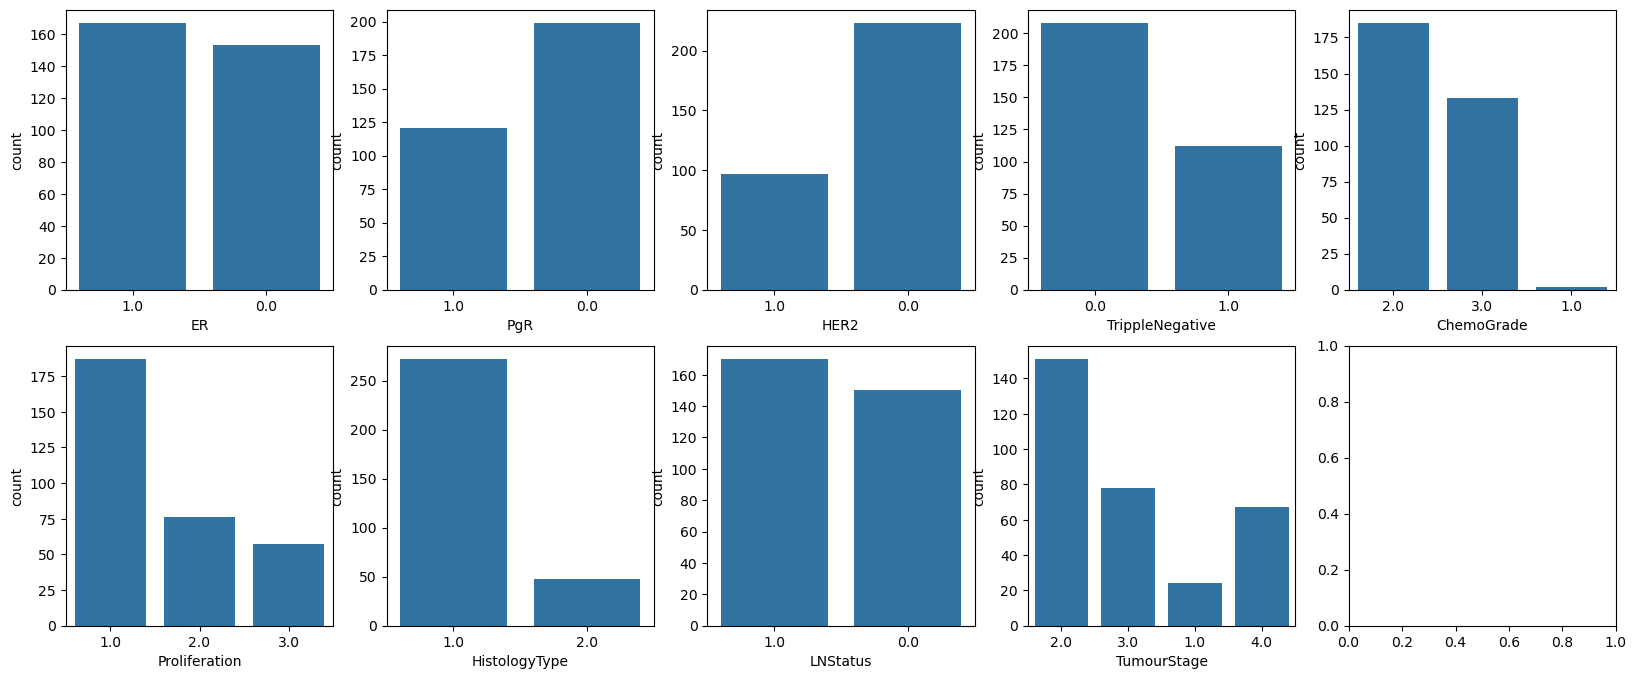

In [45]:

fig, axs = plt.subplots(2,5,figsize=(20,8))
for ax, series in zip(axs.ravel(),data_cat):
    sns.countplot(x=series,ax=ax, data=data_cat)
# axs[0,0].set_title('ER')


## Visualizing Continuous data
- so many features have outliers, these need be removed
- some are so huge, potentially indicating data entry errors

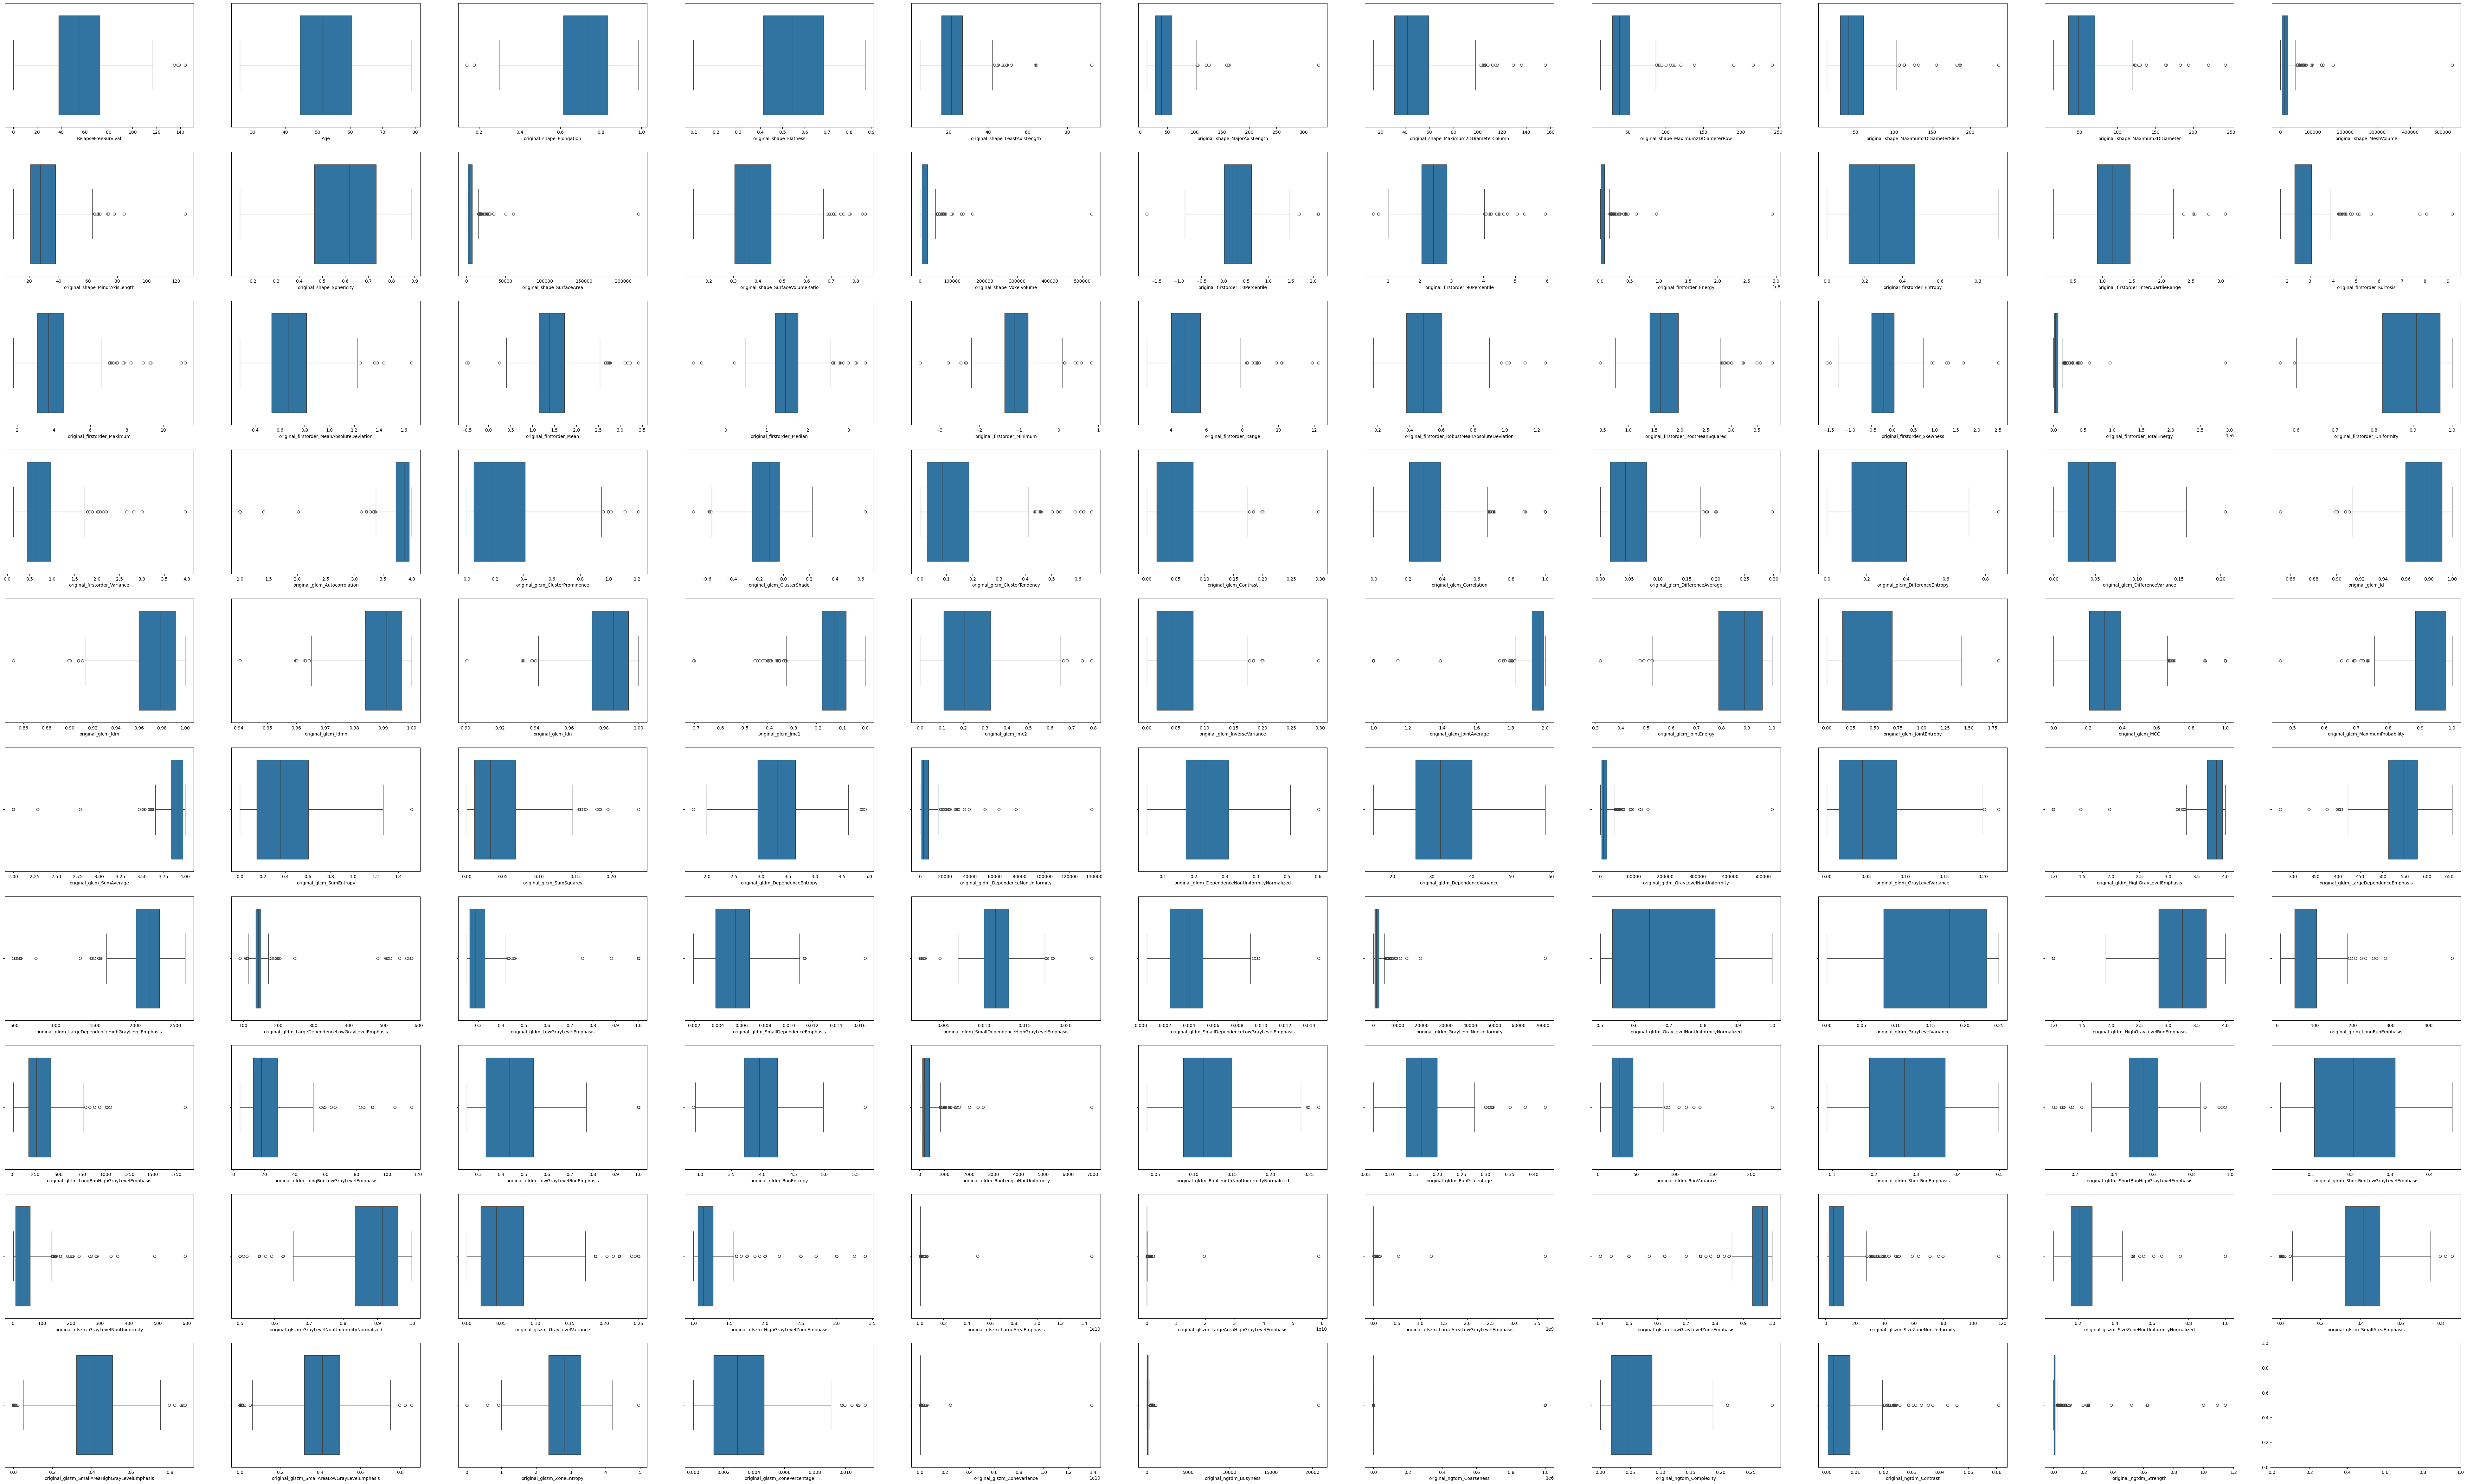

In [47]:
list_cont = [i for i in df_imp.columns.values if i not in list_cat + ['pCR'] ]
data_cont = df_imp.loc[:,list_cont]



fig, axs = plt.subplots(10,11,figsize=(100,60))
for ax, series in zip(axs.ravel(),data_cont):
    sns.boxplot(x=series,ax=ax, data=data_cont)




array([[<AxesSubplot:title={'center':'RelapseFreeSurvival'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'original_shape_Elongation'}>,
        <AxesSubplot:title={'center':'original_shape_Flatness'}>,
        <AxesSubplot:title={'center':'original_shape_LeastAxisLength'}>,
        <AxesSubplot:title={'center':'original_shape_MajorAxisLength'}>,
        <AxesSubplot:title={'center':'original_shape_Maximum2DDiameterColumn'}>,
        <AxesSubplot:title={'center':'original_shape_Maximum2DDiameterRow'}>],
       [<AxesSubplot:title={'center':'original_shape_Maximum2DDiameterSlice'}>,
        <AxesSubplot:title={'center':'original_shape_Maximum3DDiameter'}>,
        <AxesSubplot:title={'center':'original_shape_MeshVolume'}>,
        <AxesSubplot:title={'center':'original_shape_MinorAxisLength'}>,
        <AxesSubplot:title={'center':'original_shape_Sphericity'}>,
        <AxesSubplot:title={'center':'original_shape_SurfaceArea'}>,
        <AxesSubplo

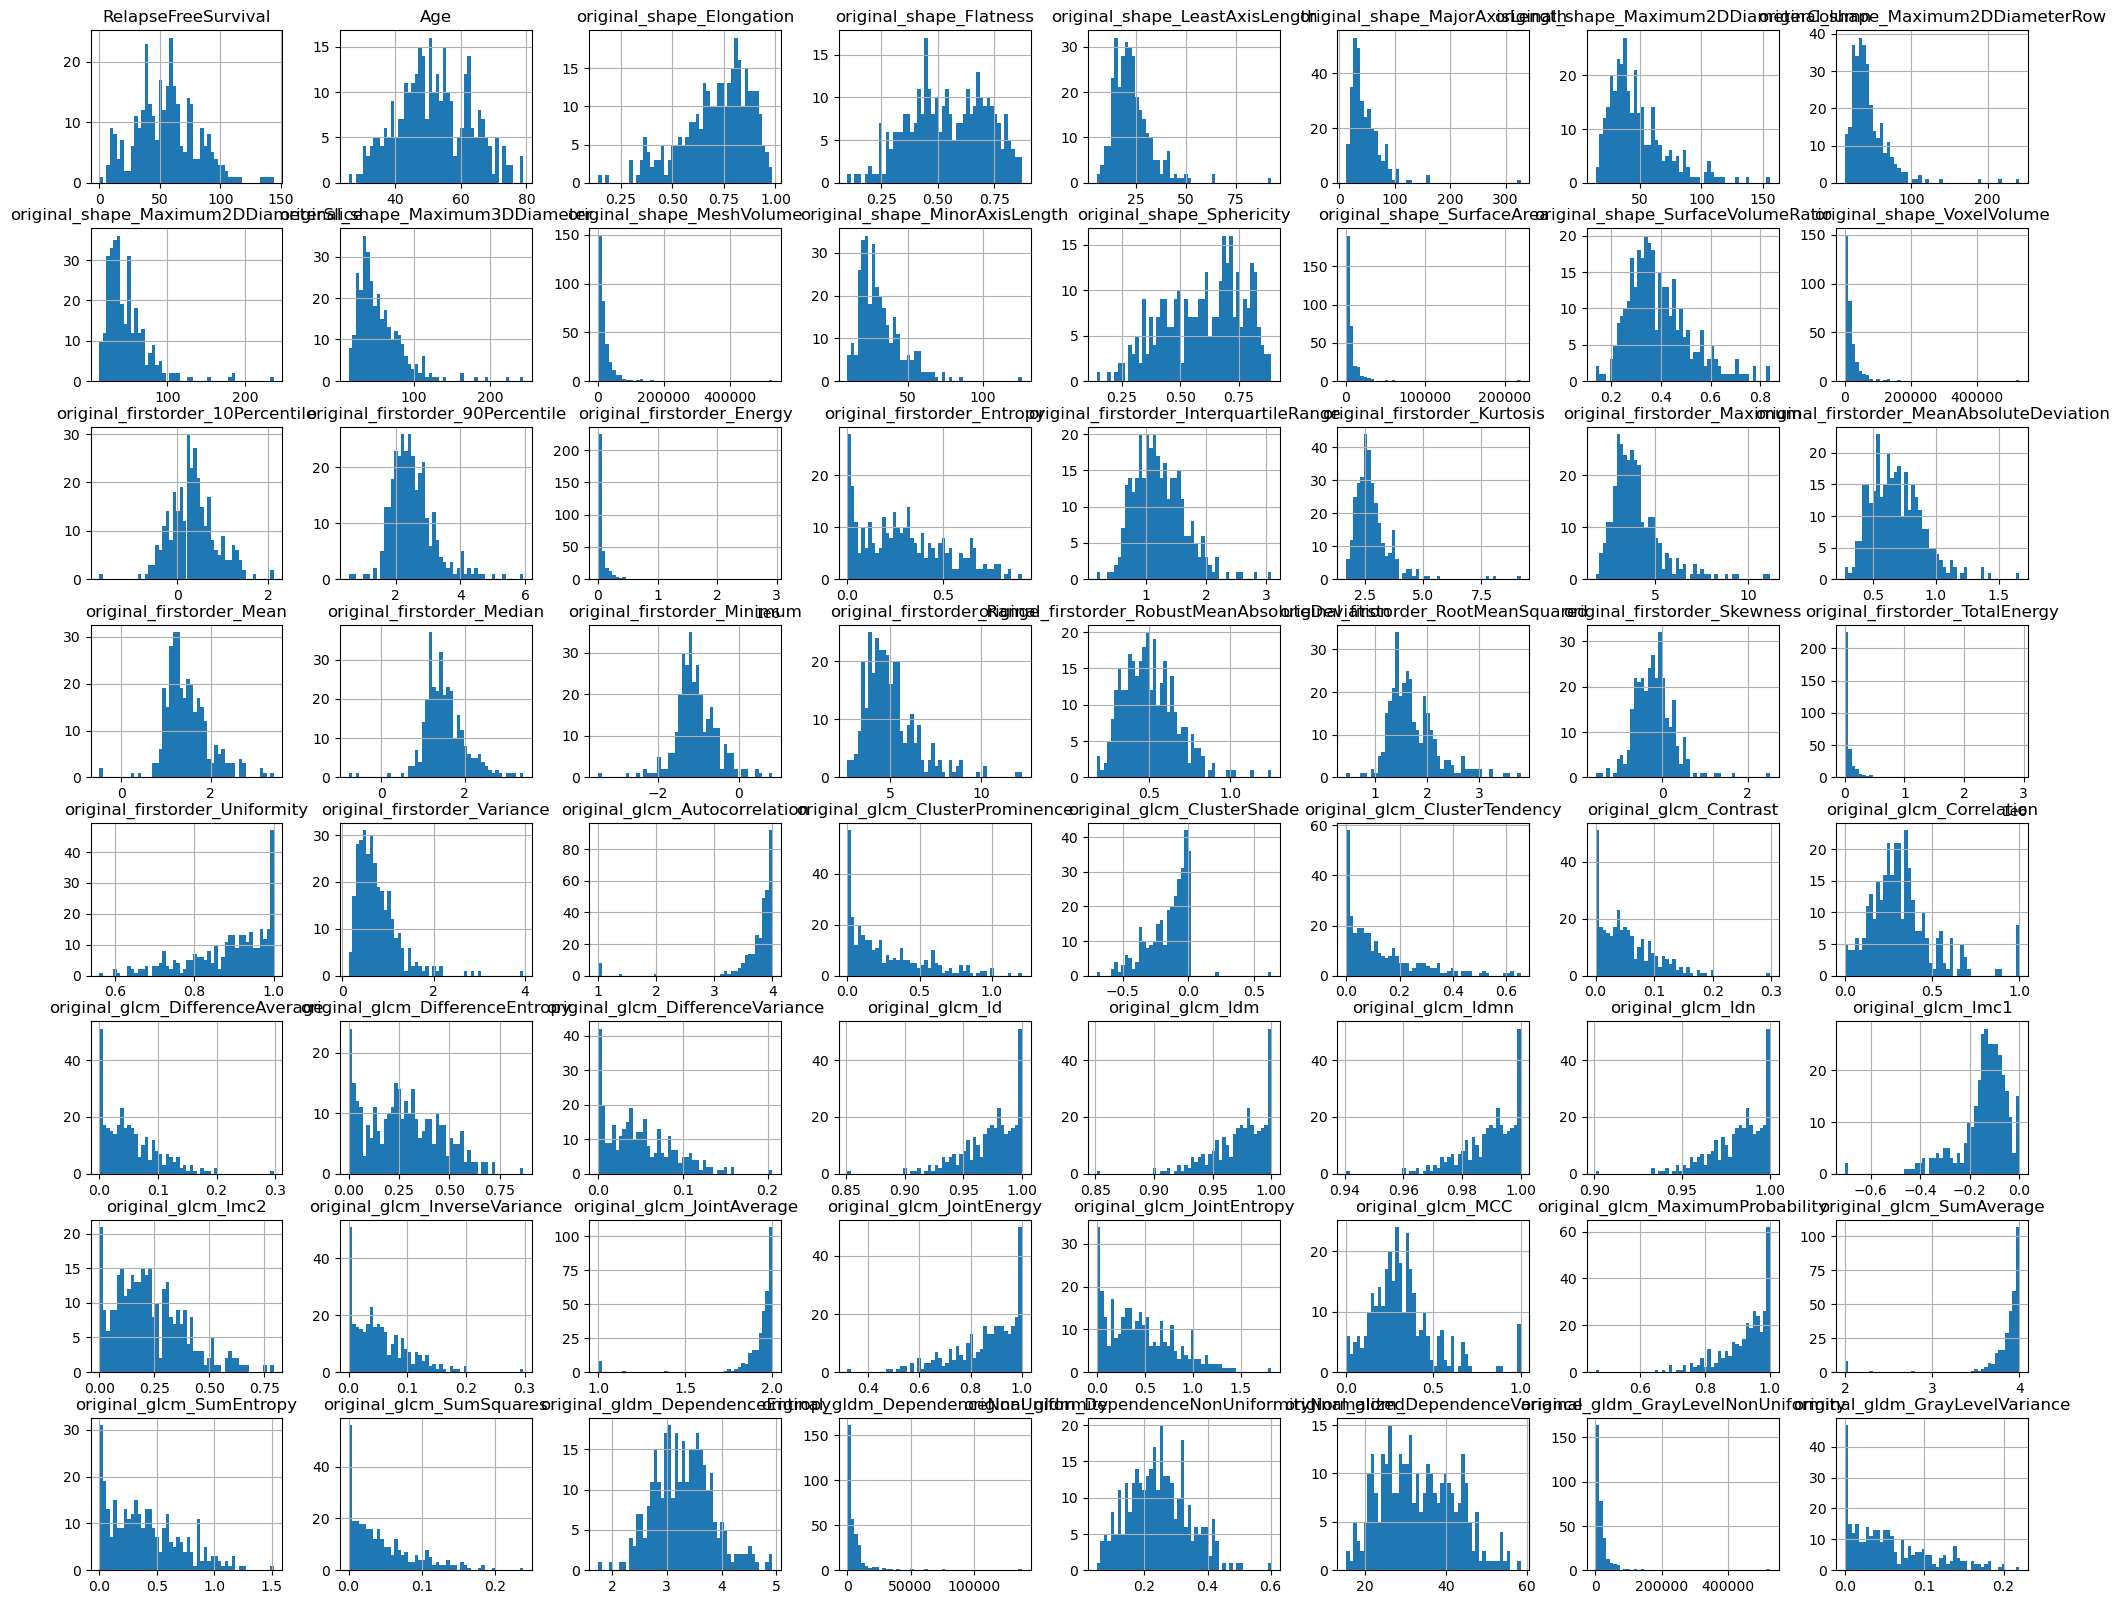

In [48]:
## Histograms for continuous data
data_cont.iloc[:,0:64].hist(bins=50,figsize=(25,20))

array([[<AxesSubplot:title={'center':'original_gldm_HighGrayLevelEmphasis'}>,
        <AxesSubplot:title={'center':'original_gldm_LargeDependenceEmphasis'}>,
        <AxesSubplot:title={'center':'original_gldm_LargeDependenceHighGrayLevelEmphasis'}>,
        <AxesSubplot:title={'center':'original_gldm_LargeDependenceLowGrayLevelEmphasis'}>,
        <AxesSubplot:title={'center':'original_gldm_LowGrayLevelEmphasis'}>,
        <AxesSubplot:title={'center':'original_gldm_SmallDependenceEmphasis'}>,
        <AxesSubplot:title={'center':'original_gldm_SmallDependenceHighGrayLevelEmphasis'}>],
       [<AxesSubplot:title={'center':'original_gldm_SmallDependenceLowGrayLevelEmphasis'}>,
        <AxesSubplot:title={'center':'original_glrlm_GrayLevelNonUniformity'}>,
        <AxesSubplot:title={'center':'original_glrlm_GrayLevelNonUniformityNormalized'}>,
        <AxesSubplot:title={'center':'original_glrlm_GrayLevelVariance'}>,
        <AxesSubplot:title={'center':'original_glrlm_HighGrayLevelRun

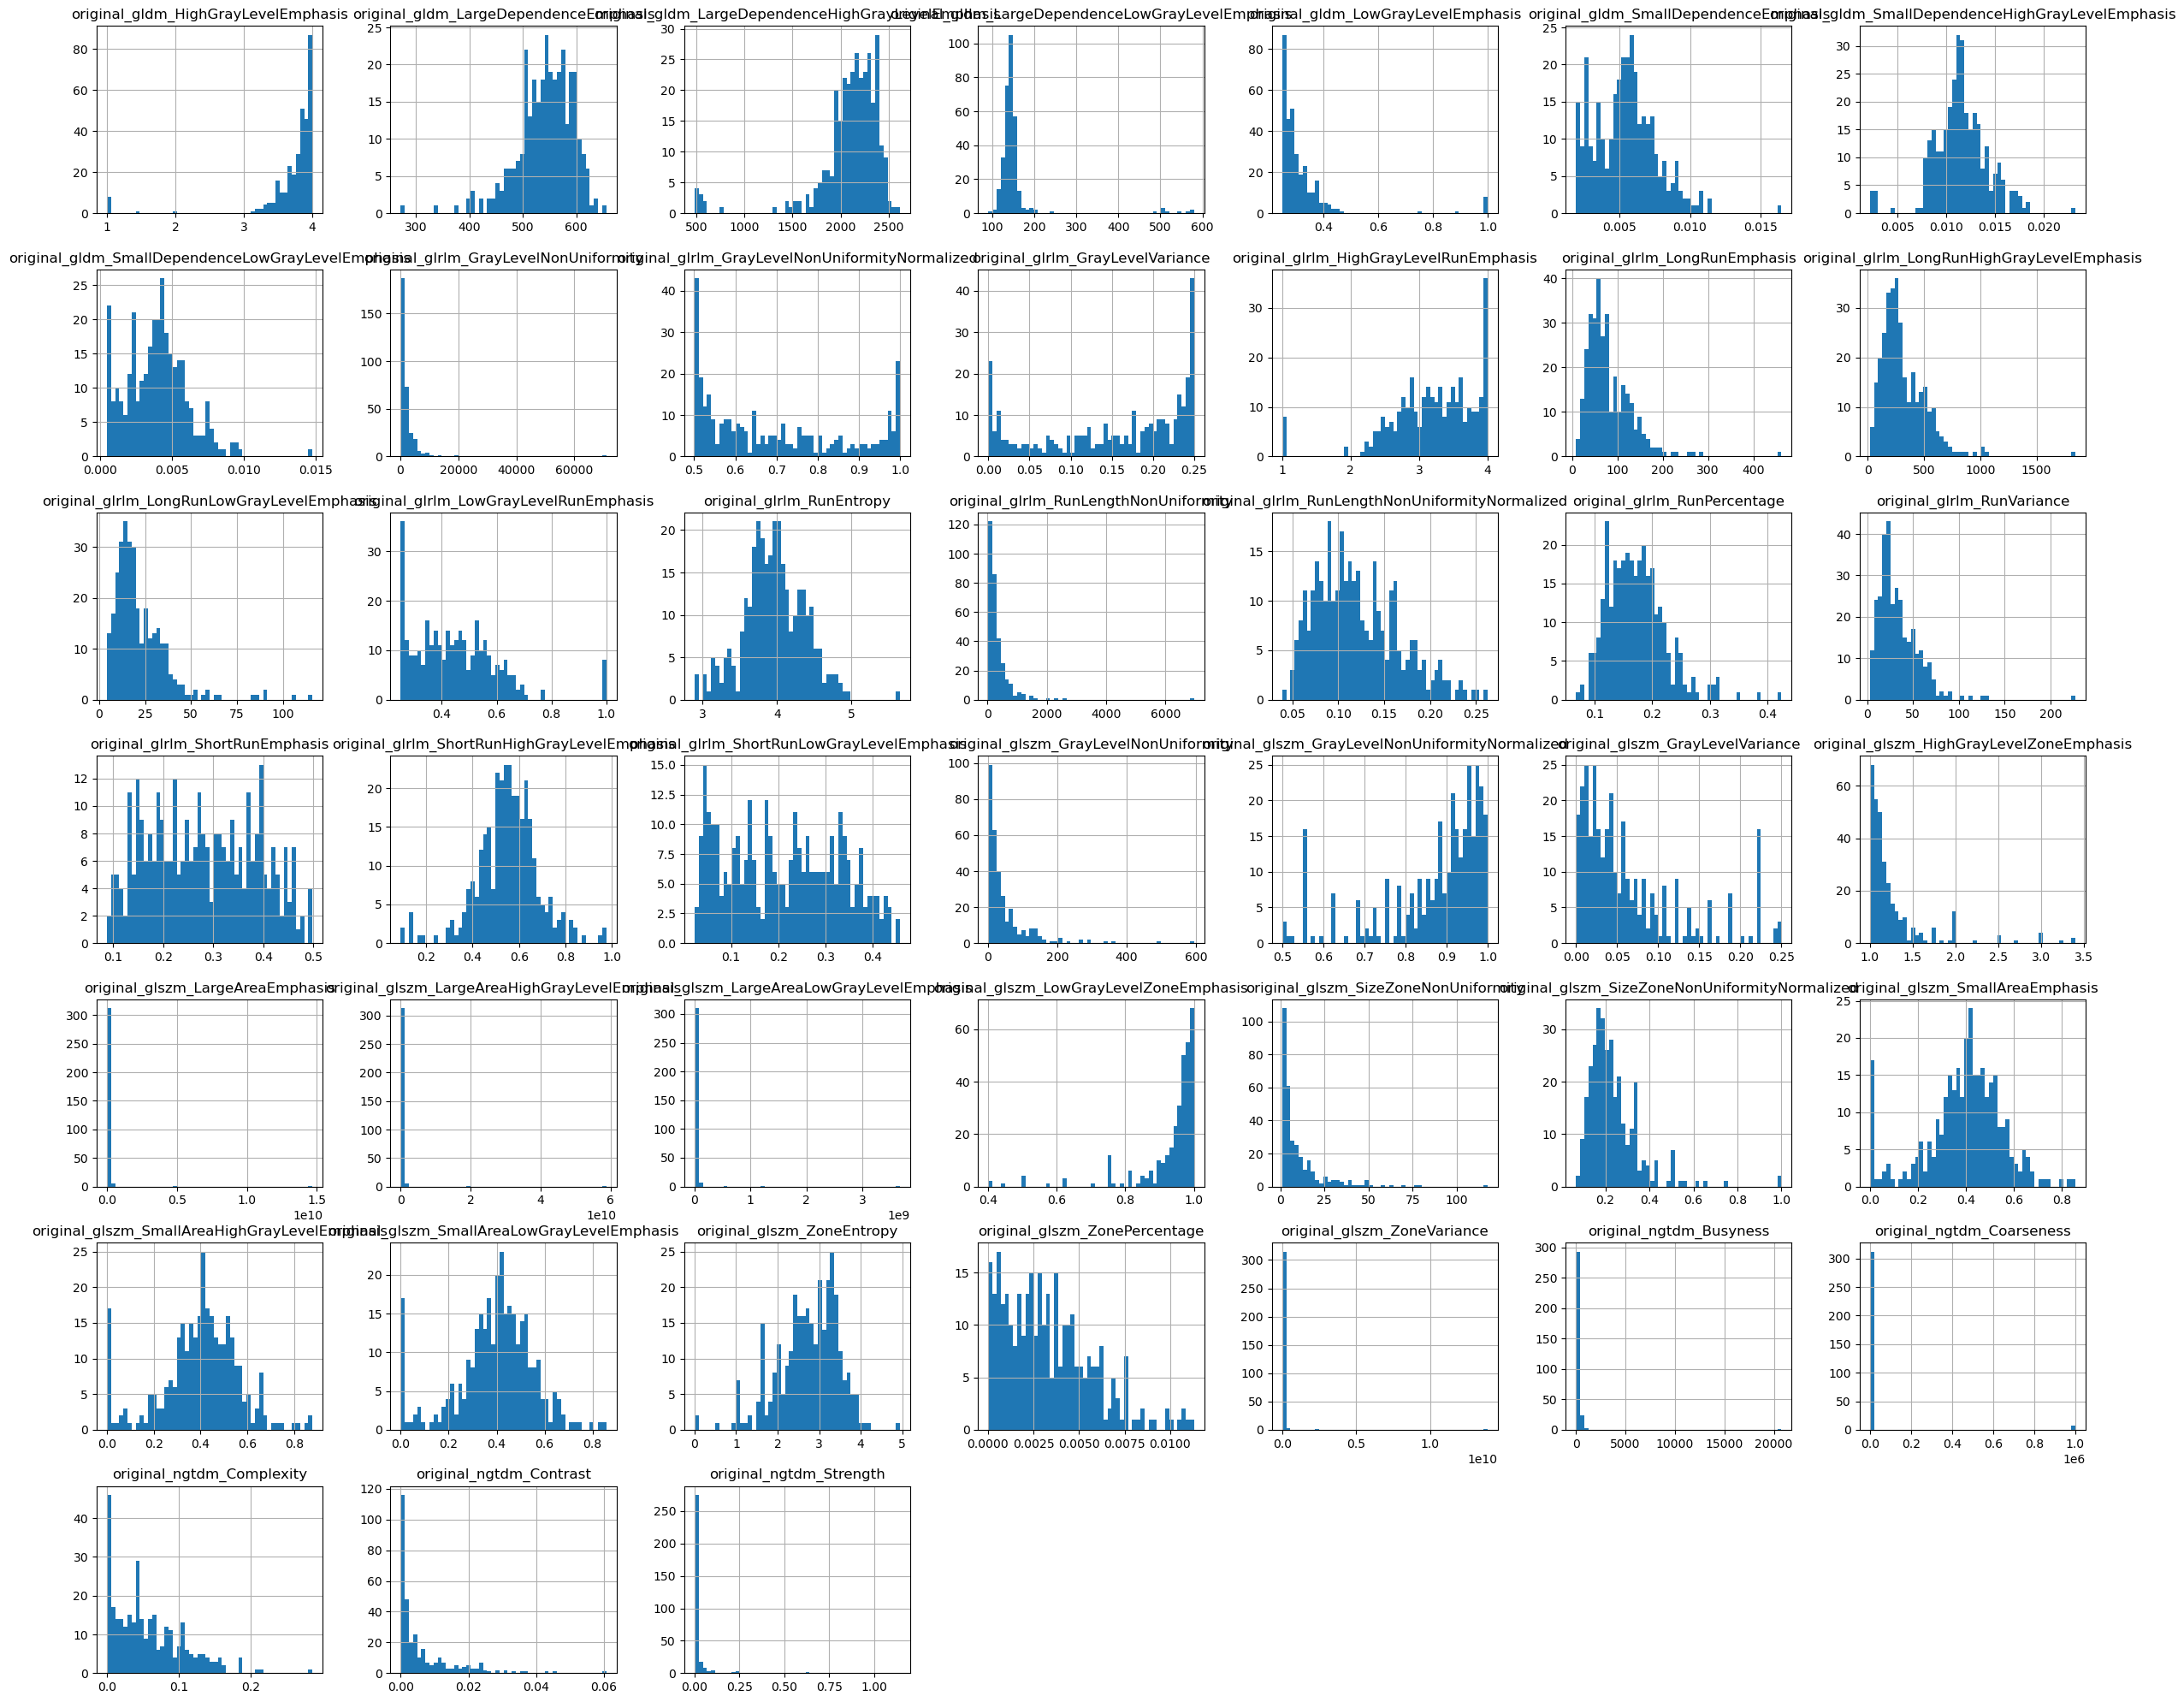

In [49]:
data_cont.iloc[:,64:data_cont.shape[1]].hist(bins=50,figsize=(30,25))

## Pairs plots
- A quick glance show weak correlarion of features with target, however strongly correlated to each other, epecially image-based data

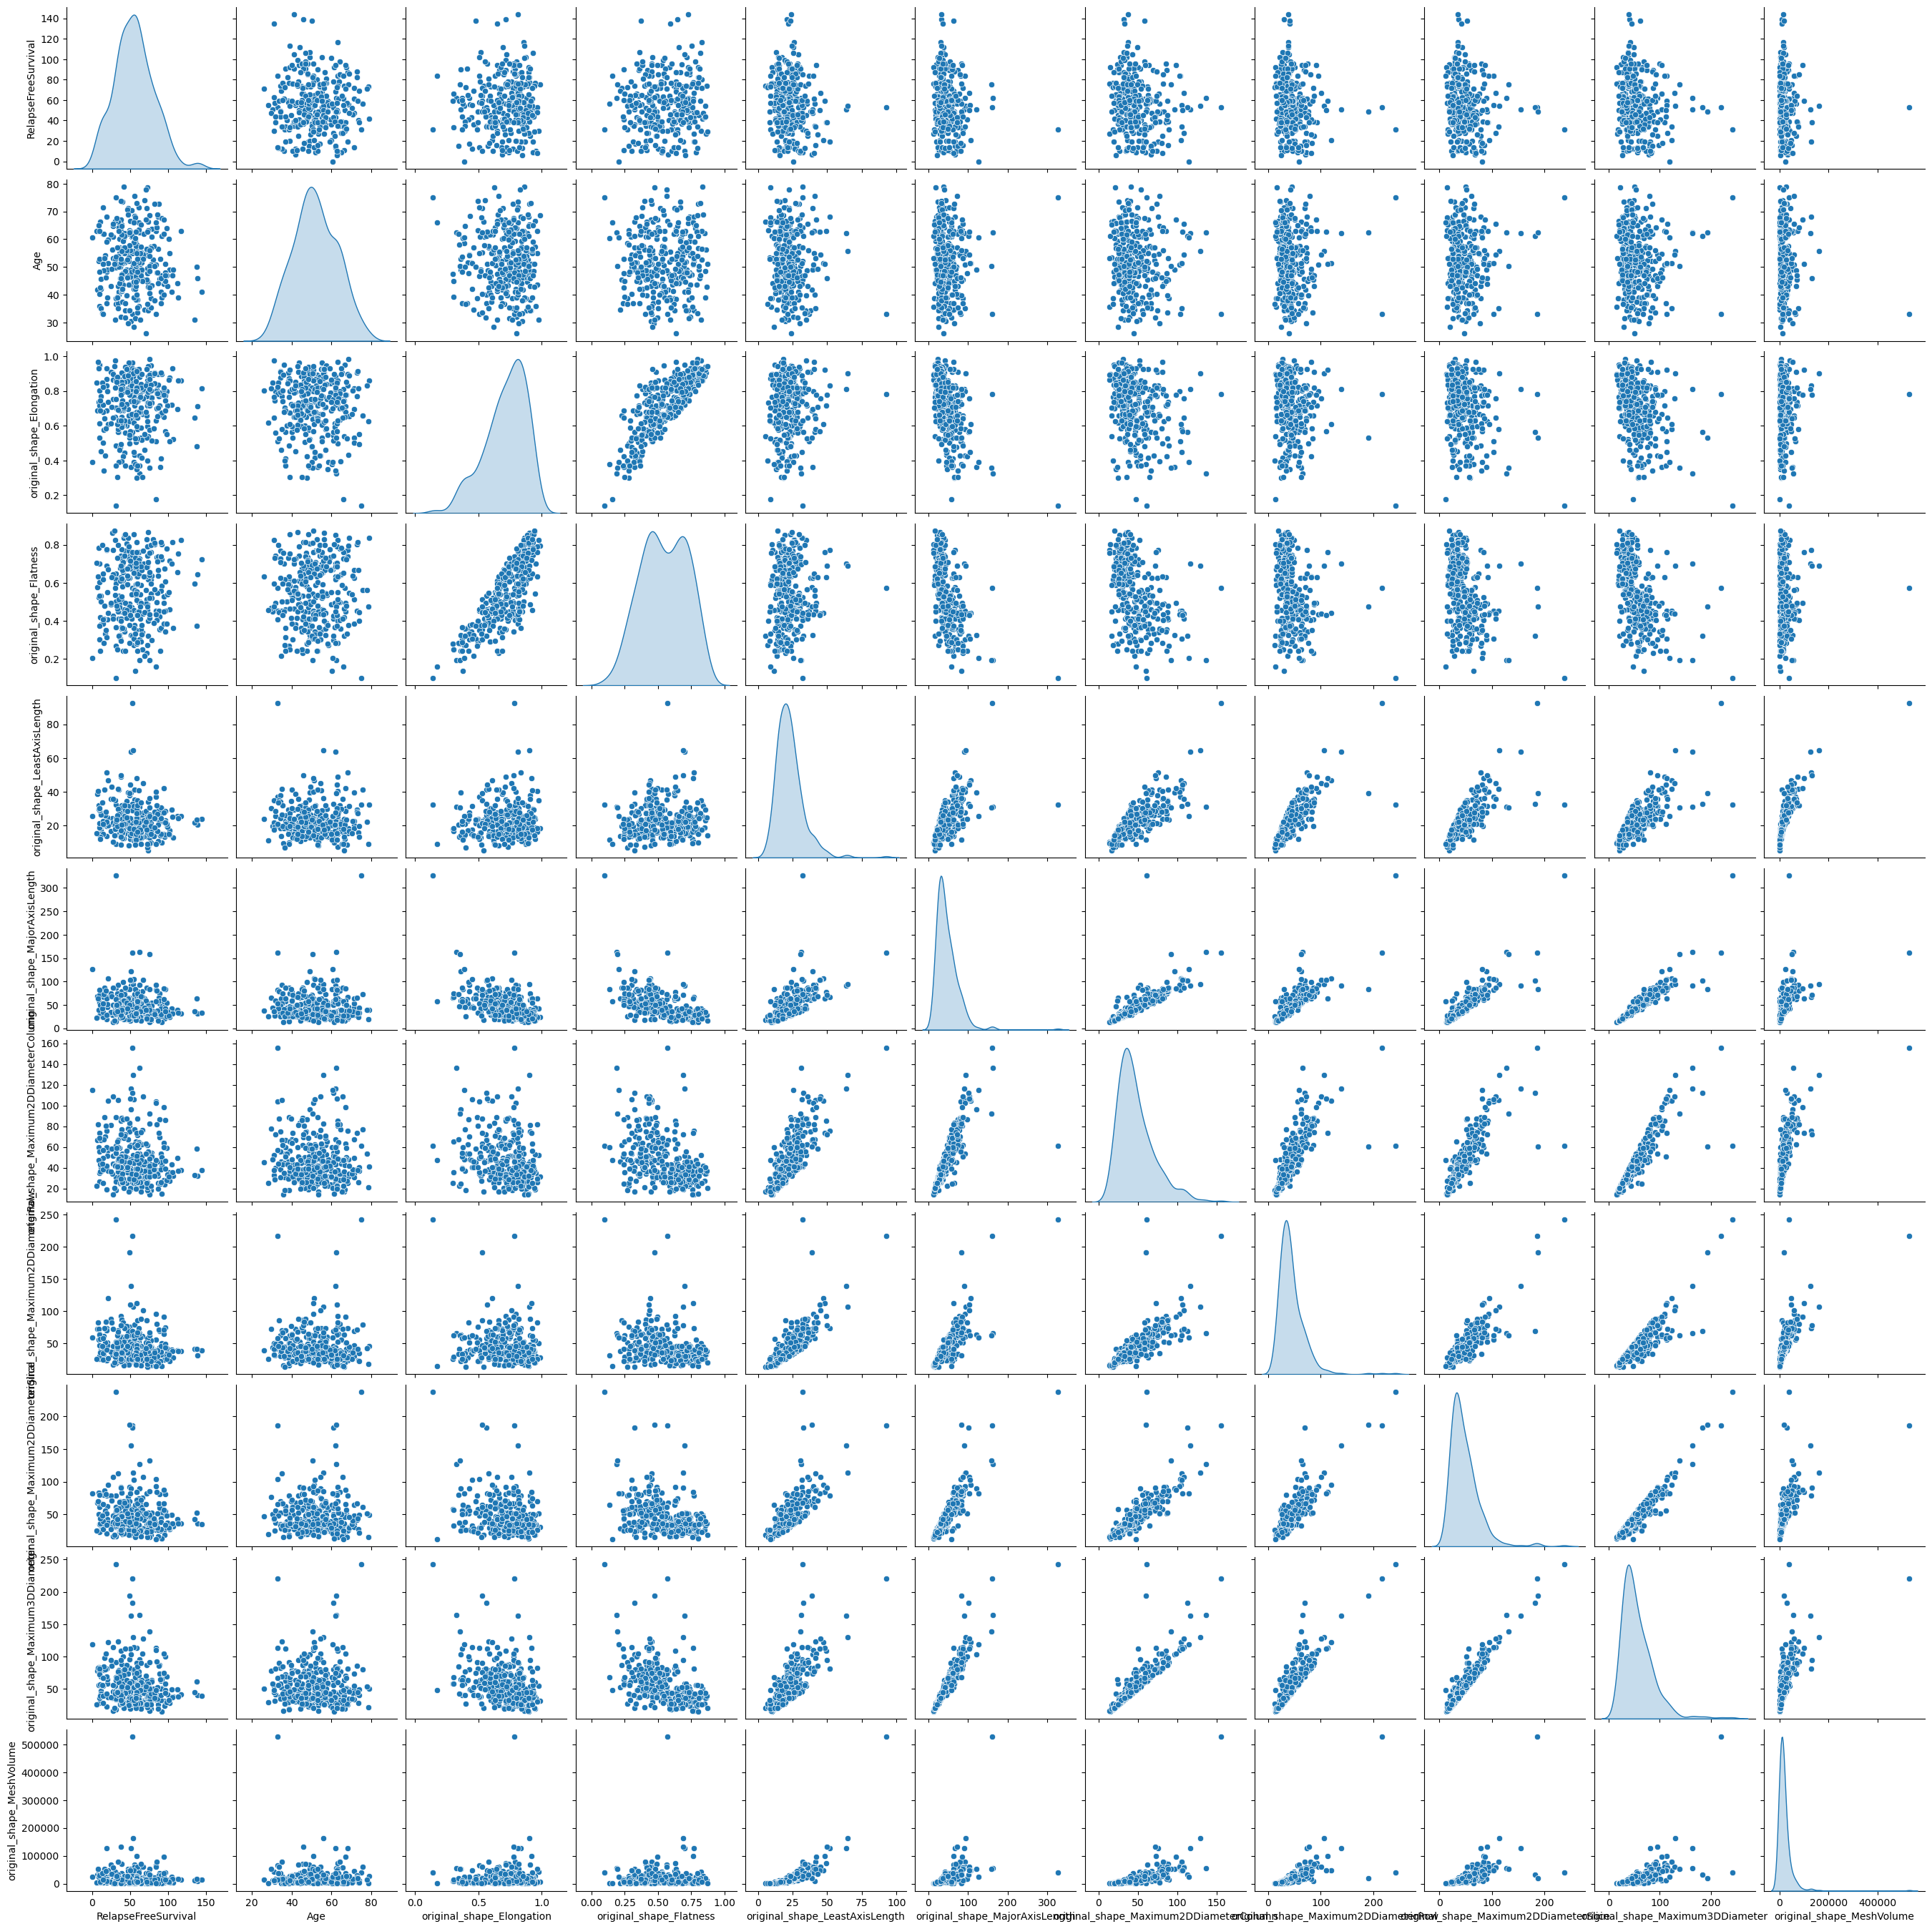

In [50]:
# Pairs plots
# add pcr to color pairs plots to check more clearly
list_cont_pcr = list_cont[:]
list_cont_pcr.insert(0,'pCR')
df.loc[:,list_cont_pcr]
# fig, axs = plt.subplots(8,6, figsize=(30,25))
# # for ax, series in zip(axs.ravel(),data_cont):
sns.pairplot(data=df.loc[:,list_cont[0:11]],diag_kind='kde')
# type(list_cont_pcr)

## Comparing feature ranges
 - Huge difference between feature ranges, scaling necessary even after removing outliers

<AxesSubplot:>

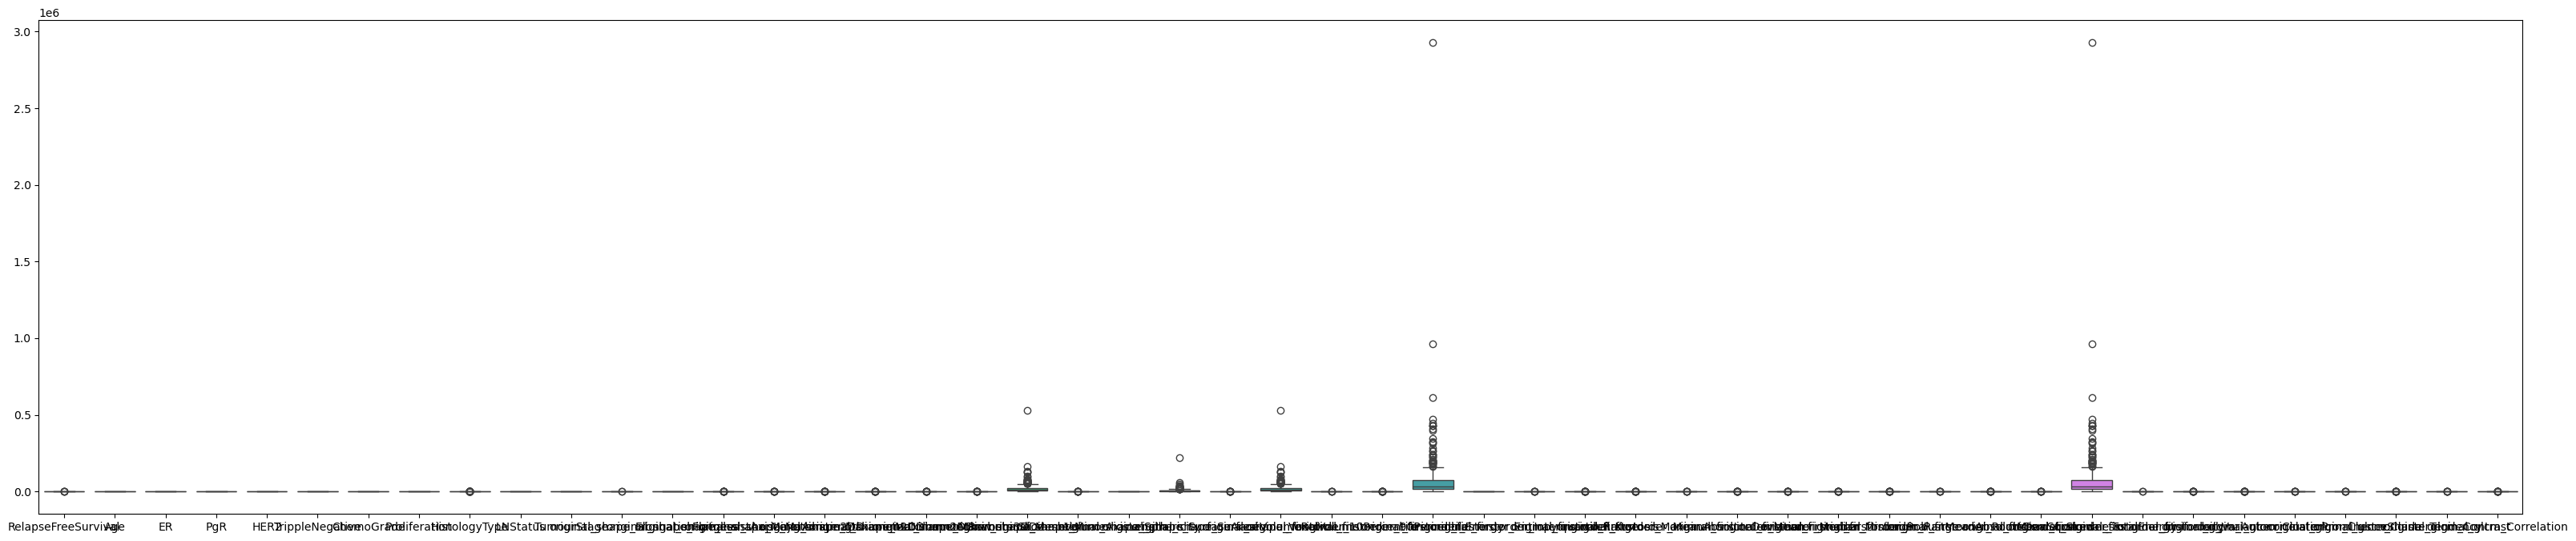

In [51]:

fig,ax=plt.subplots(1,figsize=(40,8))
sns.boxplot(data=df.iloc[:,1:50],ax=ax)

## Removing outliers
- Identify them by using factor 1.5*IQR, 
Ref: Brownlee, J., 2020. Data preparation for machine learning: data cleaning, feature selection, and data transforms in Python. Machine Learning Mastery.
- lets replace them with median values!


In [52]:
class OutlierRemover:
    """
    Takes `dataframe` as an input and list of continuous features in data frame 'cont_features_list'
    to get a list of features with outliers pass `.features_with_outliers` attribute to OutlierRemover object instance
    """
    def __init__(self,dataframe,cont_features_list):
        self.dataframe = dataframe
        self.cont_features_list = cont_features_list


    def transform(self,factor=3):
        """
        Factor is a multiplying factor to the interquartile range (IQR), cutoff = factor*IQR. Default is 3 for extreme outliers, 1.5 can be used.
        An outlier is identified as feature value that is larger than 3rd quatile + cutoff or less 1st quartile - cutoff value.
        """
        data_cont = self.dataframe.loc[:,self.dataframe.columns.isin(self.cont_features_list)]
        p25, p50, p75 = np.nanquantile(data_cont,.25,axis=0),np.nanquantile(data_cont,.5,axis=0),np.nanquantile(data_cont,.75,axis=0)

        cutoff = factor*(p75-p25) 
        lower, upper = p25 - cutoff, p75 + cutoff

        dict_upper = dict()
        dict_lower = dict()
        dict_med = dict()
        for low, up, med,col in zip(lower,upper,p50,data_cont.columns.values):
            dict_lower[col] = low
            dict_upper[col] = up
            dict_med[col] = med


        self.features_with_outliers = []
        for col in data_cont.columns.values:
            if any(data_cont[col]<dict_lower[col]) or any(data_cont[col]>dict_upper[col]):
                self.features_with_outliers.append(col)

        # for col in data_cont.columns.values:
        for col in self.features_with_outliers:
            data_cont.loc[data_cont[col]>dict_upper[col],col] = dict_med[col]
            data_cont.loc[data_cont[col]<dict_lower[col],col] = dict_med[col]

        # Combine transformed features back to original data
        df1 = self.dataframe.loc[:,~self.dataframe.columns.isin(list_cont)]
        
        return pd.merge(df1,data_cont,left_index=True,right_index=True)

## Pairs Plots
- Features not correlated with target variable
- Relationship may be nonlinear
- Features highly correlated with themselves

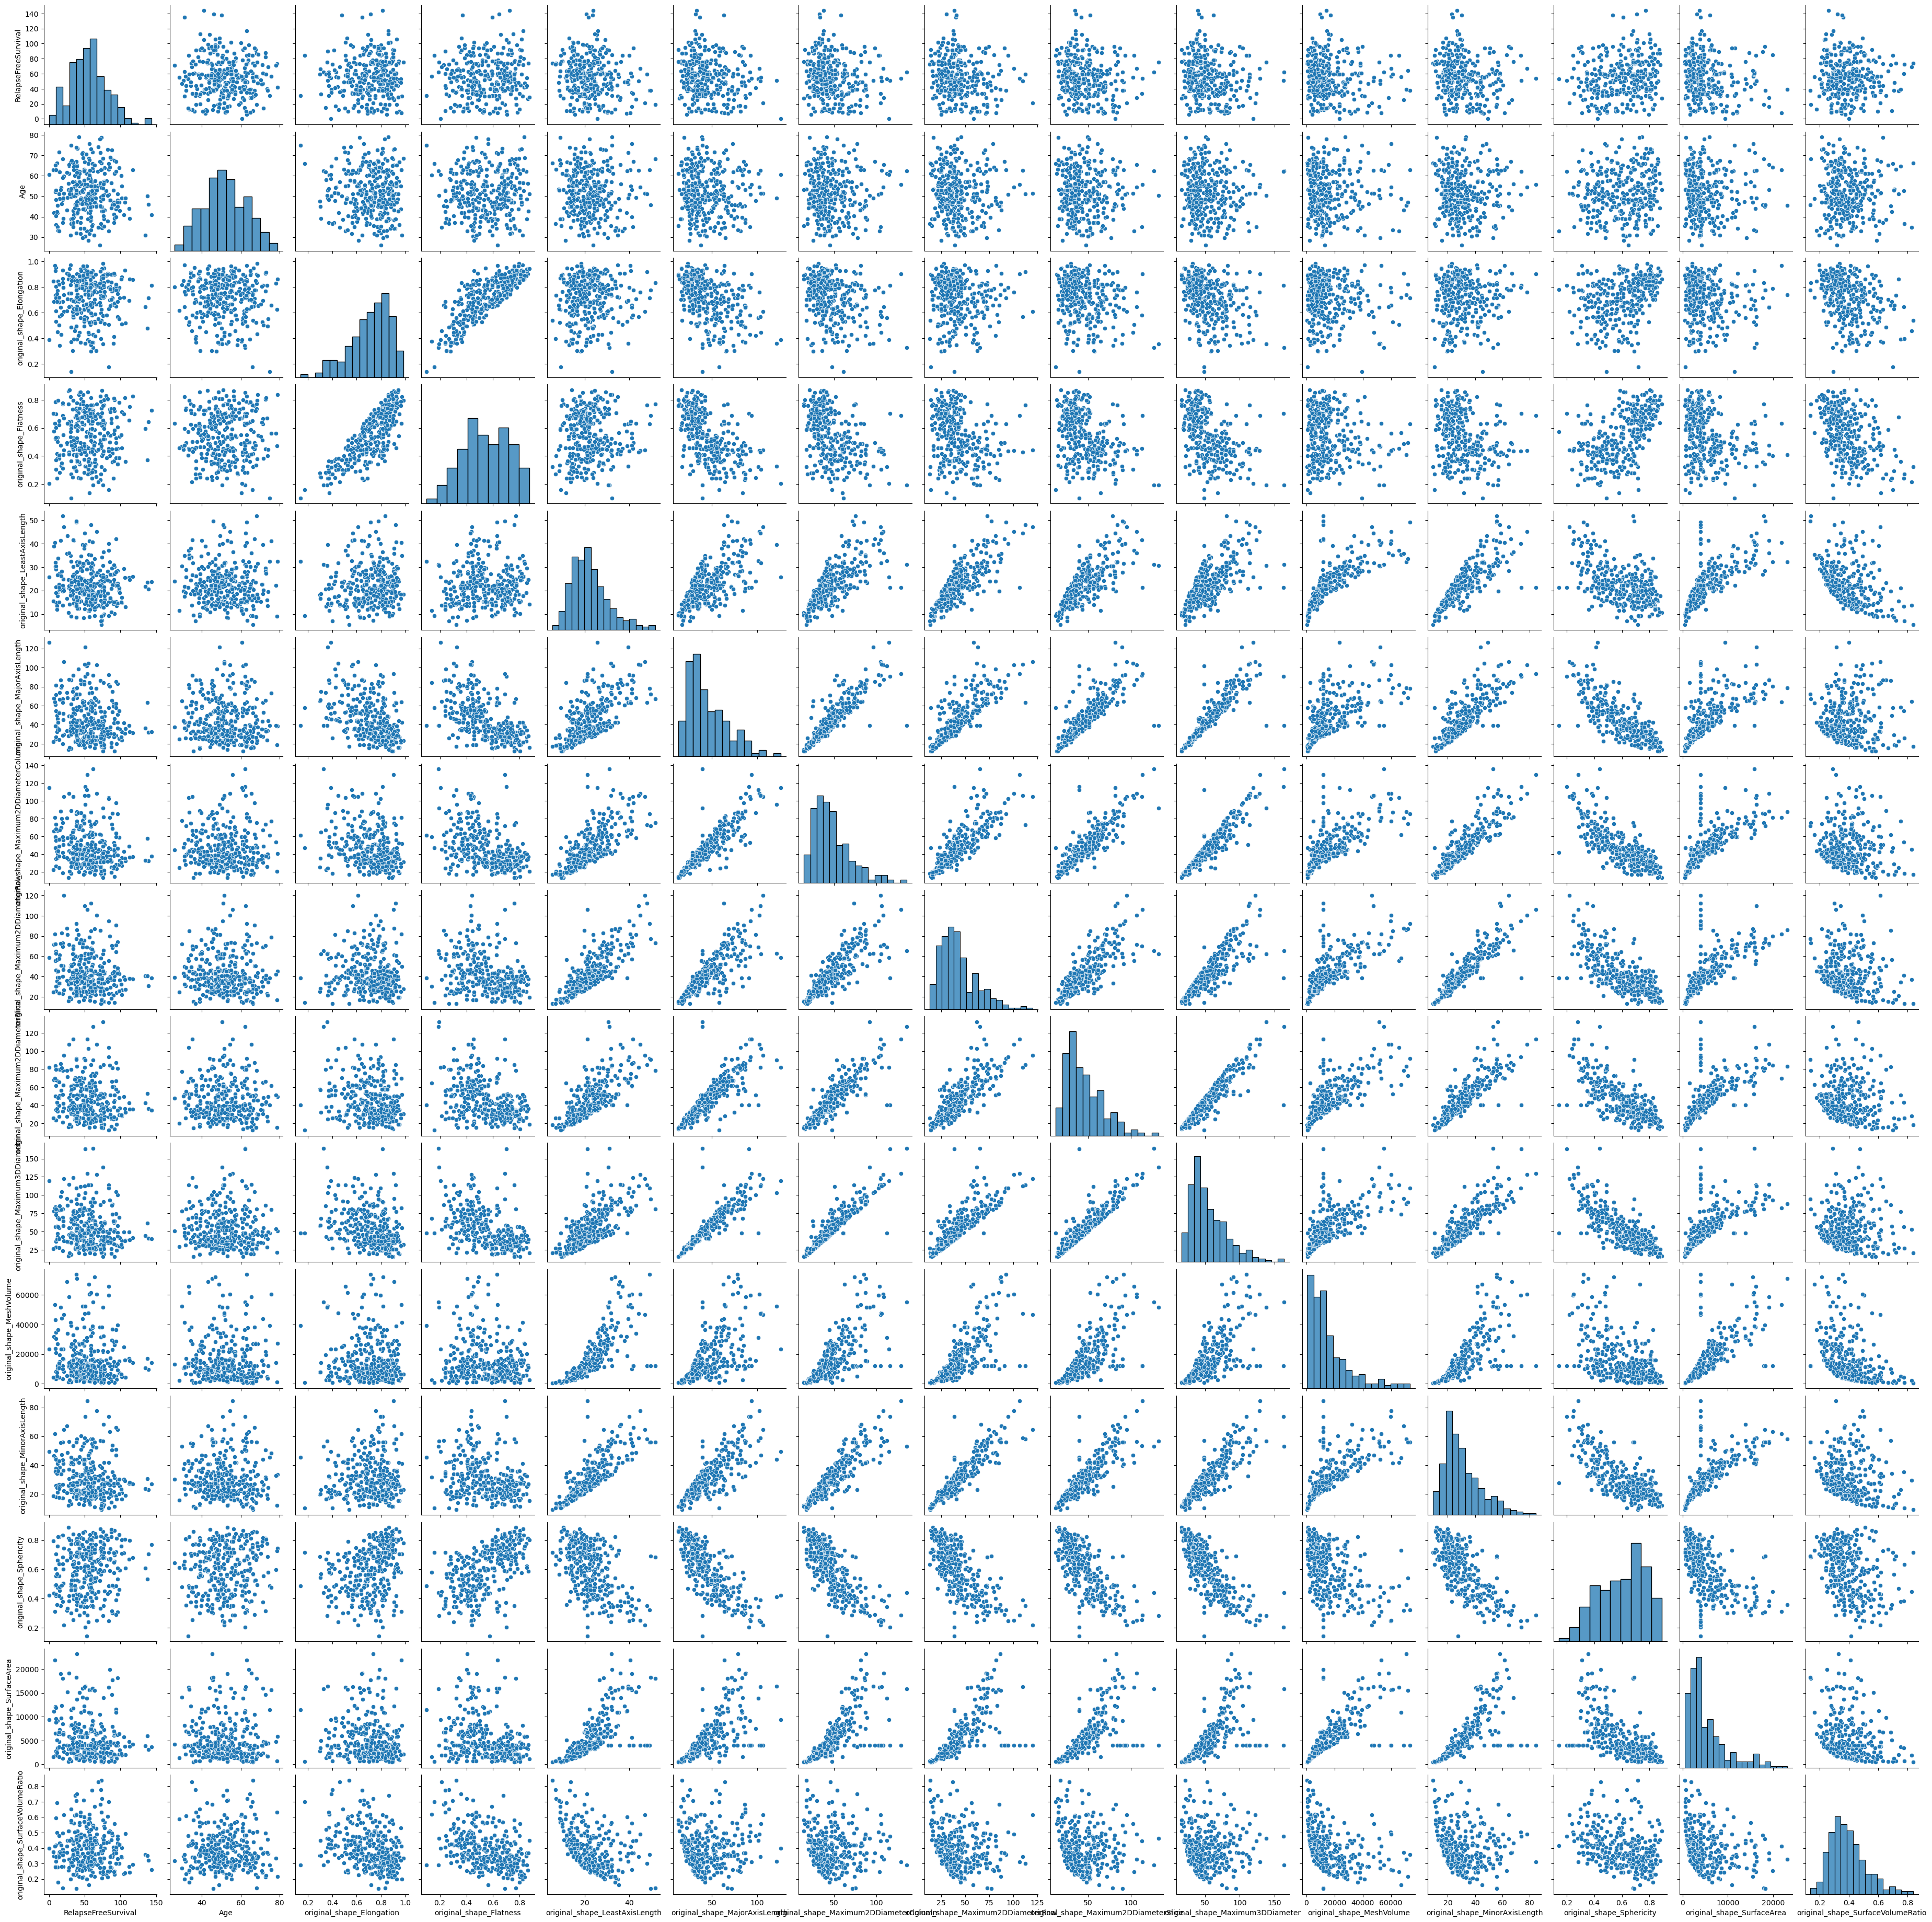

In [54]:
ourm = OutlierRemover(data_cont,list_cont)
data_cont_ourm = ourm.transform()
# Visualize pairplots
sns.pairplot(data_cont_ourm.iloc[:,0:15])

## Continous regressos with target `RelapseFreeSurvival`
- essentially no correlation
- linear algorithm may be unsuitable

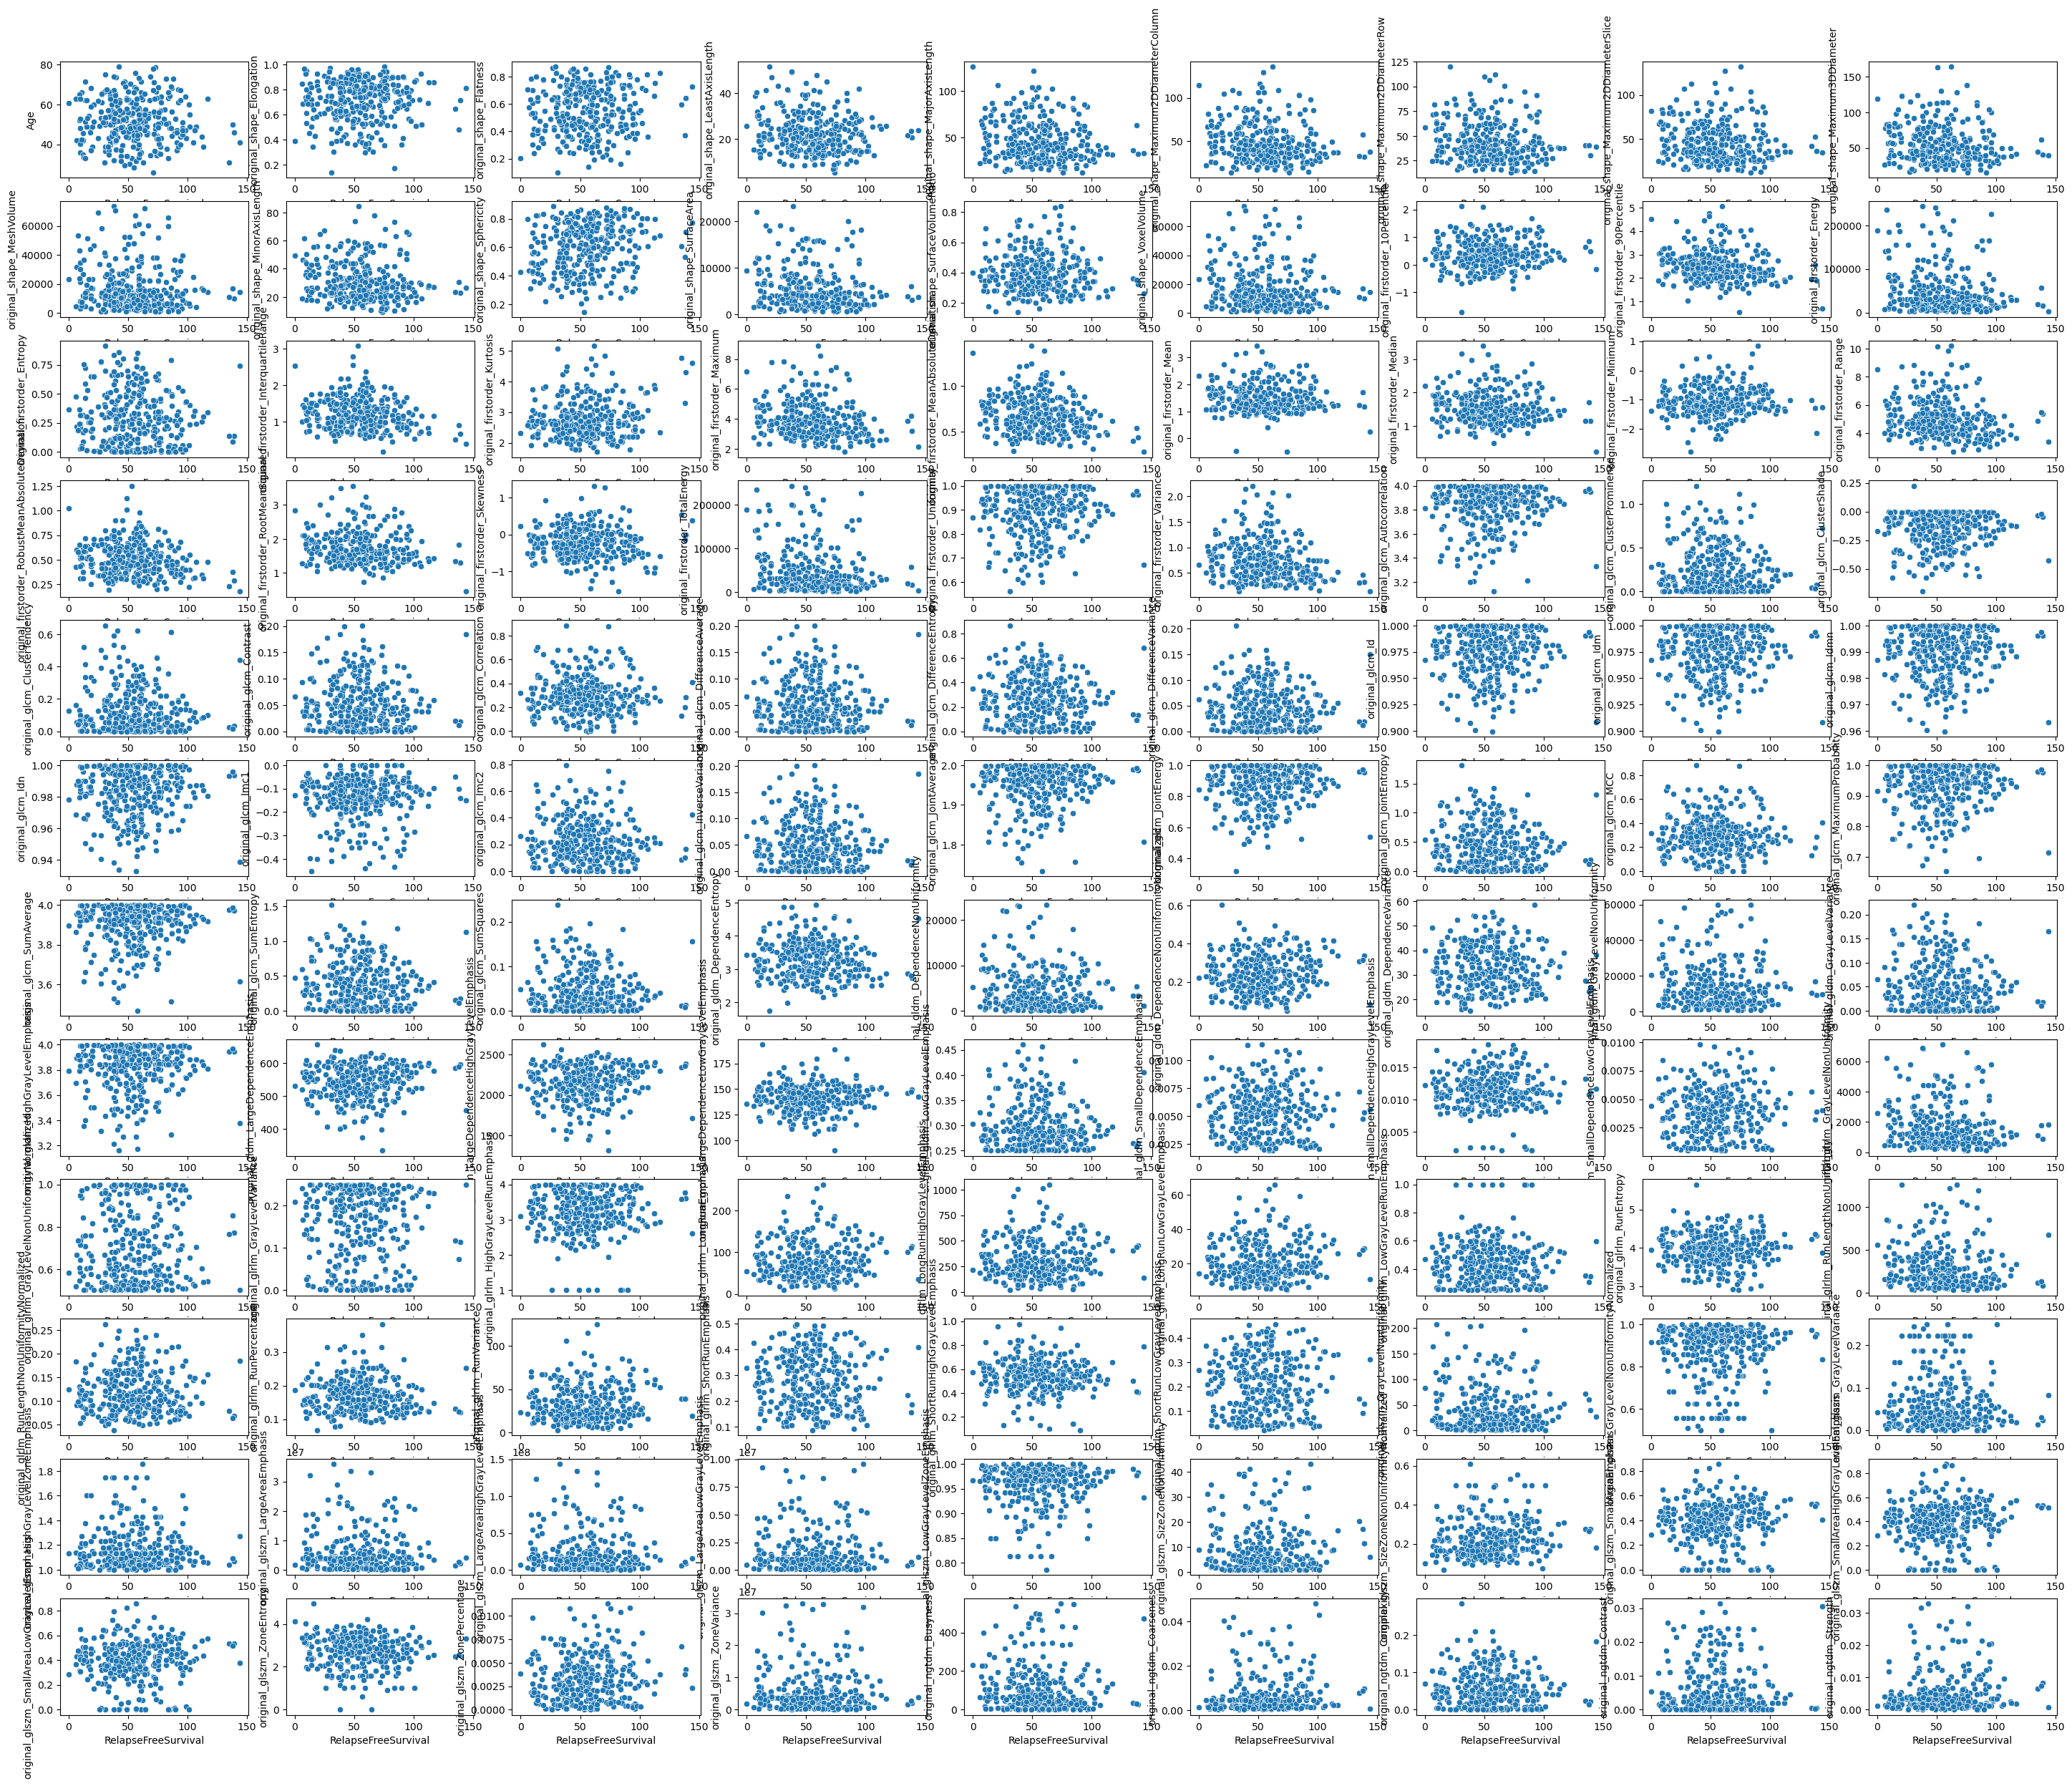

In [55]:
fig, axs = plt.subplots(12,9,figsize=(36,30))
ax = axs.ravel()

for i,j in enumerate(data_cont_ourm.columns.values[1:]):
    sns.scatterplot(x = data_cont_ourm['RelapseFreeSurvival'],y = data_cont_ourm.loc[:,j],ax=ax[i])

## Correlation Matrix
- The maximum correlation of features attained with target is around 0.23 which is typically weak, no linear relationship
- However, features among themselves are highly correlated, --multicollinearity causing unreliable estimation in models without feature selection


In [56]:
corr_vs_target = data_cont_ourm.corrwith(data_cont_ourm['RelapseFreeSurvival'])
corr_vs_target[abs(corr_vs_target)>.150]
# corr_vs_target.describe()

RelapseFreeSurvival                                1.000000
original_shape_MajorAxisLength                    -0.161988
original_shape_Sphericity                          0.172497
original_shape_SurfaceArea                        -0.151319
original_firstorder_90Percentile                  -0.186075
original_firstorder_Energy                        -0.184337
original_firstorder_InterquartileRange            -0.209825
original_firstorder_Maximum                       -0.204883
original_firstorder_MeanAbsoluteDeviation         -0.229884
original_firstorder_Range                         -0.207177
original_firstorder_RobustMeanAbsoluteDeviation   -0.216274
original_firstorder_RootMeanSquared               -0.161550
original_firstorder_TotalEnergy                   -0.184337
original_firstorder_Variance                      -0.200995
dtype: float64

## 

## Explore categorical features relative to to target
 - There is slight variation between mean `RelapseFreeSurvival` across different categorical inputs
 - ANOVA confirms that there is actually no mean difference of `RelapseFreeSurvival` across categorical inputs, potentially not good predictors for the target in linear models

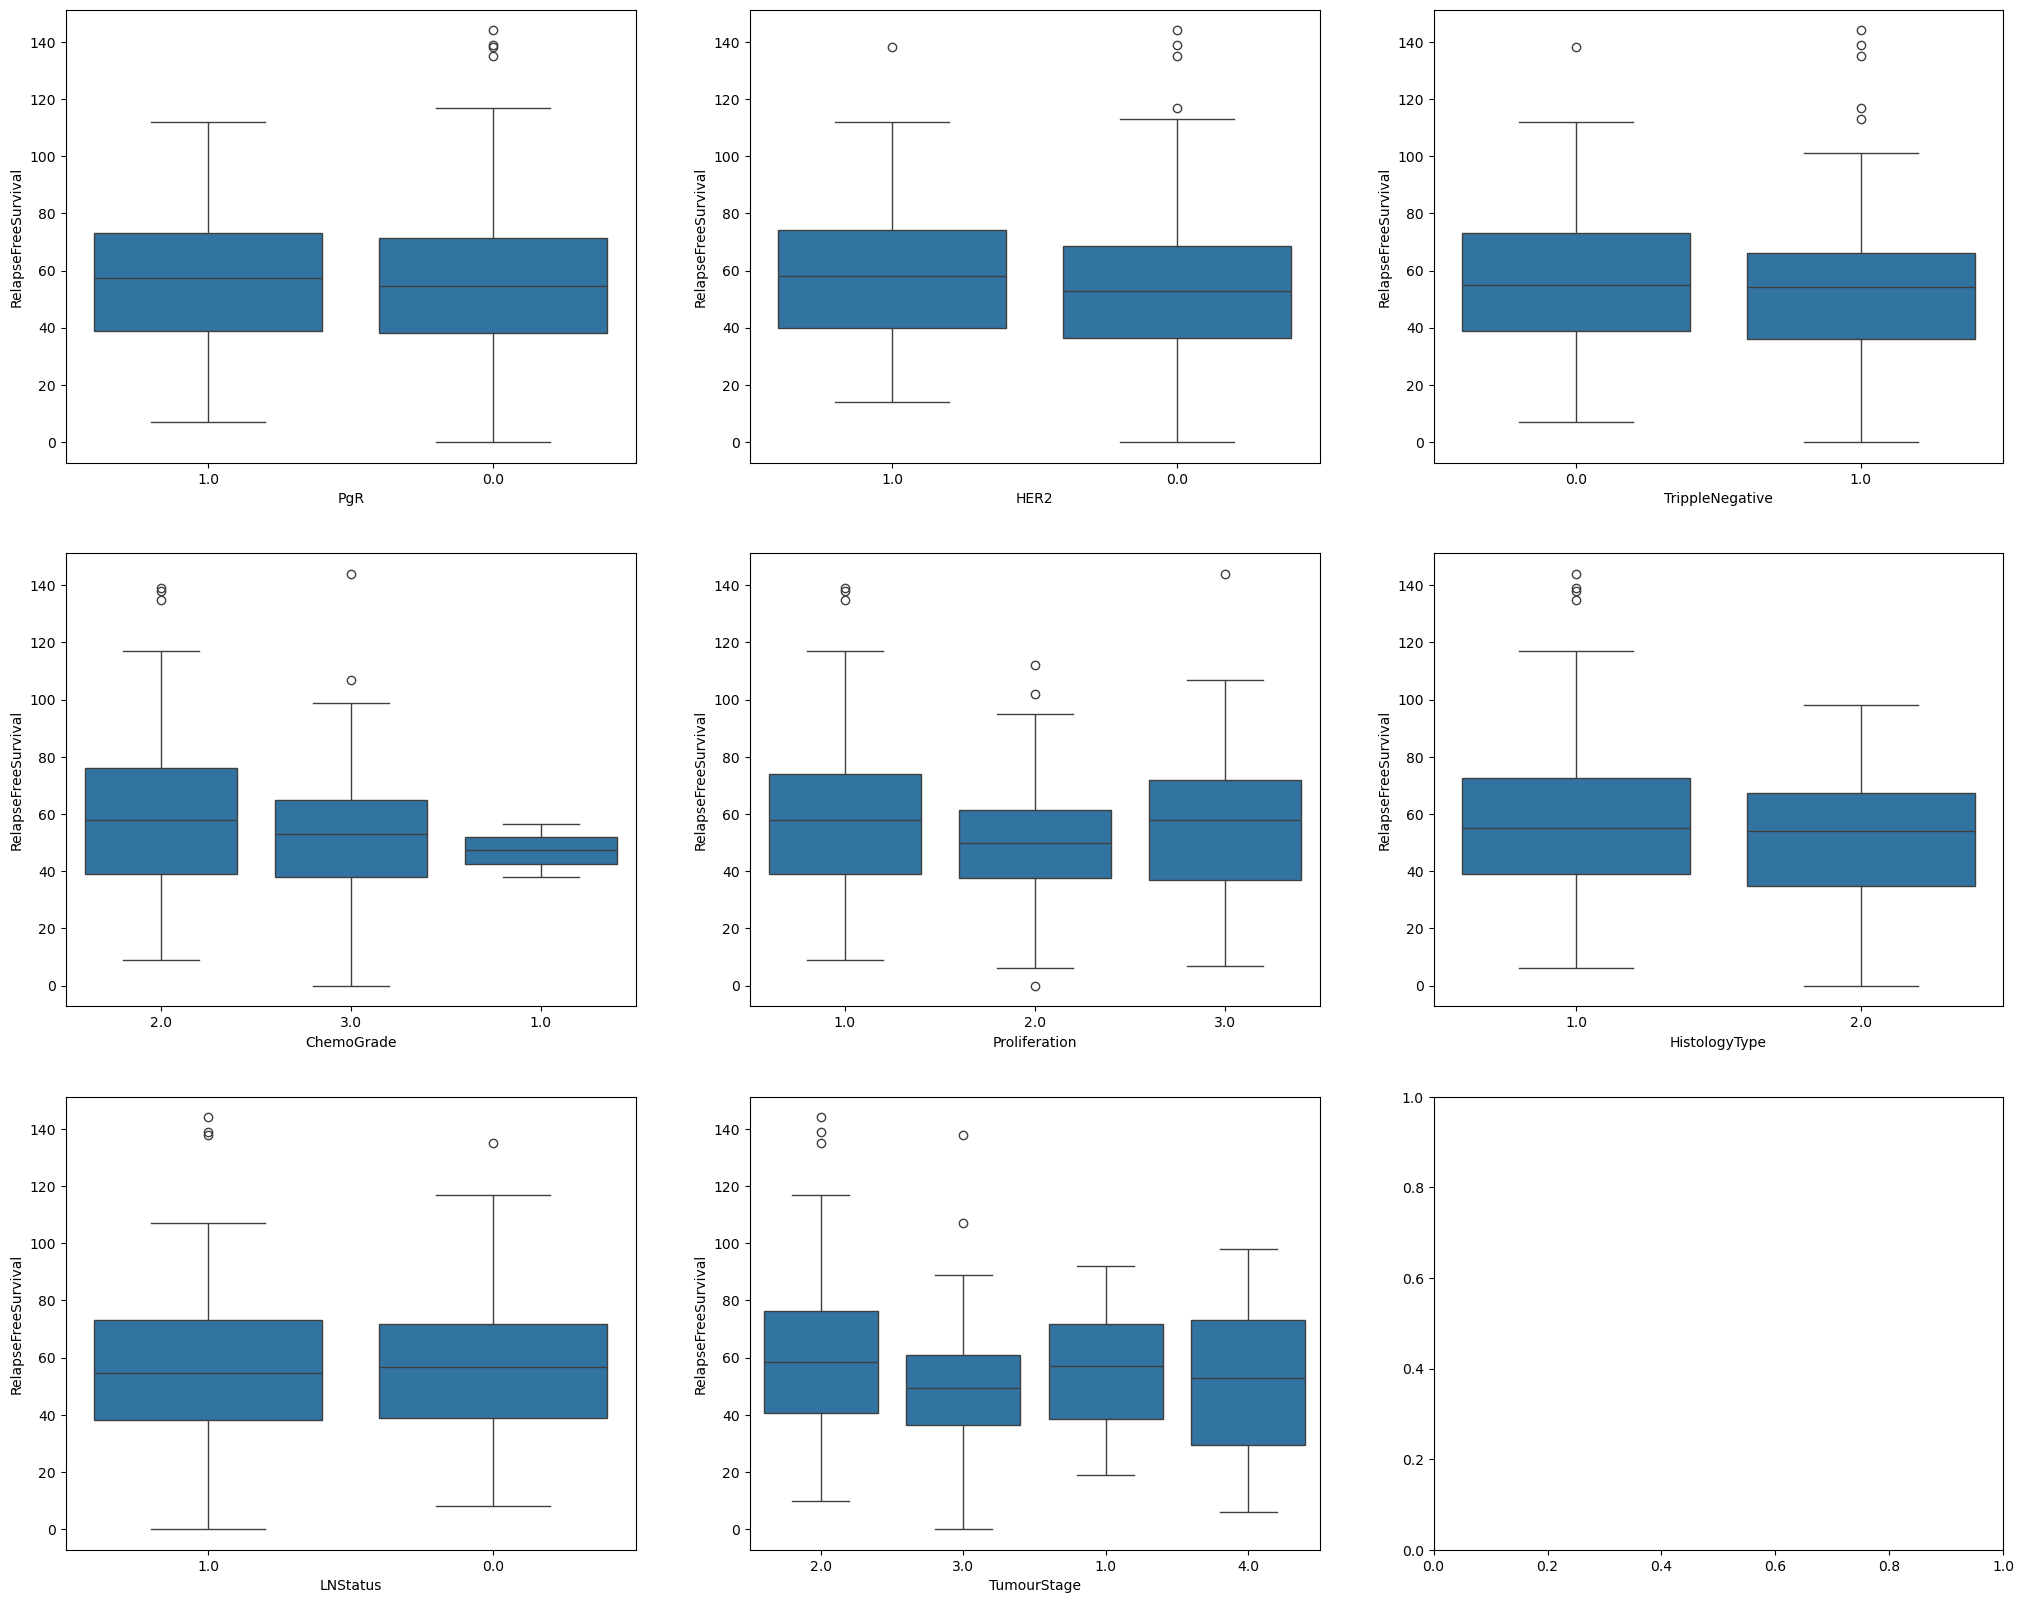

In [57]:
dfbox = pd.merge(data_cont_ourm.loc[:,['RelapseFreeSurvival']],data_cat.iloc[:,1:],left_index=True,right_index=True)
fig, axs = plt.subplots(3,3,figsize=(25,20))
ax = axs.ravel()

for i,c in enumerate(dfbox.iloc[:,1:].columns.values):
    sns.boxplot(x=c, y='RelapseFreeSurvival',ax=ax[i],data=dfbox)


# data_cont_ourm.loc[:,['RelapseFreeSurvival']]
# sns.boxplot(x = dfbox['RelapseFreeSurvival'],by=data_cat['ER'])
# fig, axs = plt.subplots(12,9,figsize=(36,30))
# 
# sns.boxplot(x=data_cont_ourm['RelapseFreeSurvival'])


#for i,j in enumerate(data_cat.columns.values[1:]):
    # sns.boxplot(x = data_cont_ourm['RelapseFreeSurvival'],y = data_cat.loc[:,j],ax=ax[i])

## ANOVA Test
- None of the p-values is statistically significant, thus no good predictor among categorical variabloes
- This tohether with exploration made above points to non-linear models

In [58]:
## ANOVA test
from sklearn.feature_selection import f_classif, SelectKBest
X_anova = data_cat.iloc[:,1:]
y_anova=data_cont_ourm.loc[:,'RelapseFreeSurvival']

fstats, pvalues = f_classif(X_anova,y_anova)

fselector = SelectKBest(f_classif, k=2)
X_selected = fselector.fit_transform(X_anova,y_anova)

# print(f"selected features: {X_anova.columns.values[fselector.get_support()]}")
print(pvalues)



[0.82901161 0.65100701 0.36159414 0.07511419 0.34417273 0.69211639
 0.6016707  0.93132518]


In [59]:
## Splitting data to features and target

target = 'RelapseFreeSurvival'
features_to_exlude_in_x = ['ID','pCR']

def split_x_y(dataframe,features_to_exlude_in_x,target):
    features_to_exlude_in_x.append(target)
    y = dataframe.loc[:,target]
    X = dataframe.loc[:,~dataframe.columns.isin(features_to_exlude_in_x)]
    return X, y

#S plitting a training set
X,y = split_x_y(data_train,features_to_exlude_in_x,target)

# Test set
X_test, y_test = split_x_y(data_test,features_to_exlude_in_x,target)
Xcols = X_test.columns.values

## Feature selection LASSO

In [81]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1,max_iter=100_000,random_state=0)
X_i = KNNImputer(n_neighbors=1).fit_transform(X)
lasso.fit(X_i,y)

c:\Users\domin\.conda\envs\MLE\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.224e+04, tolerance: 2.097e+01
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1, max_iter=100000, random_state=0)

## Random forest regressor
-  Has inbuit feature selection methods, but feature selection can be used to remain with relevant features, saves computational resources
- Thus model is trained with all features included, redundant features will be dropped automatically


In [60]:
# Apply robust scaler to image data to scale them and remove outliers
# This uses scaled data
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, RepeatedStratifiedKFold,RepeatedKFold, cross_val_score,cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.compose import TransformedTargetRegressor



## features to apply standard scaler
std_scaler_features = ['Age']
## features to apply robust scaler
rob_scaler_features = [i for i in X.columns.values if i not in std_scaler_features]


# create a pipeline to perform sequence of procesing and model training
imputer = Pipeline(steps=[('knn_imputer',KNNImputer(n_neighbors=1))])
rob_transformer = Pipeline(steps=[('knn_imputer',imputer),('rob_scaler',RobustScaler())])
std_transformer = Pipeline(steps=[('knn_imputer',imputer),('std_scaler',StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('rob_scaler',rob_transformer,rob_scaler_features),
                                               ('std_scaler',std_transformer,std_scaler_features)])

regressor = RandomForestRegressor(random_state=0)
# standarizing target
transformer = StandardScaler()
regressor = TransformedTargetRegressor(regressor=regressor,transformer=transformer)
model = Pipeline(steps=[('preprocessor',preprocessor),('regressor',regressor)])


param_grid = param_grid = [
 {'regressor__regressor__n_estimators': [50,100,200], 
  'regressor__regressor__max_features': [4, 6, 8,15],
 'regressor__regressor__bootstrap': [False,True]}]#, 'regressor__n_estimators': [3, 5,10], 'regressor__max_features': [2, 3, 4],
# }]

grid_search = GridSearchCV(estimator=model,param_grid=param_grid,cv=5,scoring='neg_mean_absolute_error')
grid_search.fit(X=X,y=y)
reg_rf = grid_search.best_estimator_
best_parameters = grid_search.best_params_

y_pred = reg_rf.predict(X)
mae_train_reg_rf = mean_absolute_error(y_true=y,y_pred=y_pred)

# cross_val_predict(reg_rf,X,y)

mae_cv_reg_rf = cross_val_score(reg_rf,X,y,scoring='neg_mean_absolute_error')



# Predict and test
y_pred = reg_rf.predict(X_test)
mae_test_reg_rf = mean_absolute_error(y_true=y_test,y_pred=y_pred)
print('MAE train:',mae_train_reg_rf)
print(f"MAE CV: {-np.mean(mae_cv_reg_rf):.3f}, cv_sd: {np.std(mae_cv_reg_rf):.3f}, MAE Test: {mae_test_reg_rf:.3f}")
reg_rf

MAE train: 7.31613671875
MAE CV: 20.124, cv_sd: 2.400, MAE Test: 25.199


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   Pipeline(steps=[('knn_imputer',
                                                                                    KNNImputer(n_neighbors=1))])),
                                                                  ('rob_scaler',
                                                                   RobustScaler())]),
                                                  ['ER', 'PgR', 'HER2',
                                                   'TrippleNegative',
                                                   'ChemoGrade',
                                                   'Proliferation',
                                                   'HistologyType', 'LNStatus',
                                                   'TumourStage',
                                                   'original_shape_Elongation',
                                                   'original_sha...
                                                   'original_firstorder_Kurtosis',
                                                   'original_firstorder_Maximum', ...]),
                                                 ('std_scaler',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   Pipeline(steps=[('knn_imputer',
                                                                                    KNNImputer(n_neighbors=1))])),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Age'])])),
                ('regressor',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(max_features=6,
                                                                            n_estimators=200,
                                                                            random_state=0),
                                            transformer=StandardScaler()))])

In [61]:
## Storing model performance metrics
def model_performance(name,cross_validation_score,test_score):
    metrics = {'name':name,'mae_cv':-np.mean(cross_validation_score),'sd':np.std(cross_validation_score),'mae_test':test_score}
    return metrics

perfopmance_reg_rf = model_performance('Random Forest 1',mae_cv_reg_rf,mae_test_reg_rf)

# perf_reg_rf = {'mae_cv':mae_cv_reg_rf,'sd':np.std(mae_cv_reg_rf),'mae_test':mae_test_reg_rf}

In [62]:
# Feature importances
reg_rf.named_steps
importance = reg_rf.named_steps['regressor'].regressor_.feature_importances_
features = reg_rf.named_steps['preprocessor'].get_feature_names_out()
df_importance = pd.DataFrame({'feature':features,'importance':importance})
# feature importance total decrease of node impurity weighted by probability of reaching that node, approximated by proportion of samples reaching the node.
df_importance.sort_values(by='importance',ascending=False)
df_importance
# df_importance[df_importance['importance']>0.015]

feature  importance
0                           rob_scaler__ER    0.001115
1                          rob_scaler__PgR    0.001729
2                         rob_scaler__HER2    0.001159
3              rob_scaler__TrippleNegative    0.001337
4                   rob_scaler__ChemoGrade    0.004322
..                                     ...         ...
112  rob_scaler__original_ngtdm_Coarseness    0.009551
113  rob_scaler__original_ngtdm_Complexity    0.005797
114    rob_scaler__original_ngtdm_Contrast    0.004891
115    rob_scaler__original_ngtdm_Strength    0.009142
116                        std_scaler__Age    0.011161

[117 rows x 2 columns]

In [63]:
x = y_test-y_pred
(abs(x)>25).sum()/len(x)

0.4

## Random forest regressor, without scaling
- Cross validation mean absolute error declines, better than scaled version

In [64]:
## Re-estimating the model with unscaled data
# 1. Remove outliers from data
# 2. Create new pipeline excluding scalers

out_remover = OutlierRemover(dataframe=data_train,cont_features_list=list_cont)
data_2 = out_remover.transform()

X_unscaled,y_unscaled = split_x_y(data_2,features_to_exlude_in_x,target)

# Pipeline
# create a pipeline to perform sequence of procesing and model training
imputer = Pipeline(steps=[('knn_imputer',KNNImputer(n_neighbors=1))])
preprocessor = ColumnTransformer(transformers=[('knn_imputer',imputer,Xcols)])

regressor = RandomForestRegressor(random_state=0)

model = Pipeline(steps=[('preprocessor',preprocessor),('regressor',regressor)])


param_grid = [
 {'regressor__n_estimators': [50,80,100,200], 'regressor__max_features': [2, 4, 6, 10,15],
 'regressor__bootstrap': [False,True]}]#, 'regressor__n_estimators': [3, 5,10], 'regressor__max_features': [2, 3, 4],
# }]

grid_search = GridSearchCV(estimator=model,param_grid=param_grid,cv=5,scoring='neg_mean_absolute_error')
grid_search.fit(X=X_unscaled,y=y_unscaled)
reg_rf2 = grid_search.best_estimator_
best_parameters = grid_search.best_params_

mae_cv_reg_rf2 = cross_val_score(reg_rf2,X,y,scoring='neg_mean_absolute_error')


# Apply pipeline
y_pred = reg_rf2.predict(X_test)
mae_test_reg_rf2 = mean_absolute_error(y_true=y_test,y_pred=y_pred)

print(f"CV Score: {-np.mean(mae_cv_reg_rf2):.3f}, cv_sd: {np.std(mae_cv_reg_rf2):.3f}, Test_score: {mae_test_reg_rf2:.3f}")
reg_rf2

CV Score: 20.093, cv_sd: 2.178, Test_score: 25.094


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('knn_imputer',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=1))]),
                                                  array(['Age', 'ER', 'PgR', 'HER2', 'TrippleNegative', 'ChemoGrade',
       'Proliferation', 'HistologyType', 'LNStatus', 'TumourStage',
       'original_shape_Elongation', 'original_shape_Flatness',
       'original_shape_LeastAxisLength', 'orig...
       'original_glszm_SmallAreaLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage',
       'original_glszm_ZoneVariance', 'original_ngtdm_Busyness',
       'original_ngtdm_Coarseness', 'original_ngtdm_Complexity',
       'original_ngtdm_Contrast', 'original_ngtdm_Strength'], dtype=object))])),
                ('regressor',
                 RandomForestRegressor(max_features=10, random_state=0))])

In [65]:
## Store model performance metrics
perfopmance_reg_rf2 = model_performance('Random Forest 2',mae_cv_reg_rf2,mae_test_reg_rf2)

## Support Vector Machine regressor
- PCA is used for dimensianality reduction for image data
- Model based feature selection --LASSO returns zero as all slopes are essentially zero given very low correlation between features and target
- For categorical features, all features did not pass ANOVA test, all p-values were large
- Used PCA instead to reduce dimensionality


In [66]:
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel, SelectKBest,VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso

X,y = split_x_y(data_train,features_to_exlude_in_x,target)

X_test,y_test = split_x_y(data_test,features_to_exlude_in_x,target)

Xcols = X.columns.values

knn_imputer = KNNImputer(n_neighbors=1)
# lasso = Lasso(alpha=2,random_state=0)
# lasso = Pipeline(steps=[('imputer',knn_imputer),('select_featurs',SelectFromModel(lasso))])
rob_transformer = Pipeline(steps=[('knn_imputer',knn_imputer),('rob_scaler',RobustScaler())])
std_transformer = Pipeline(steps=[('knn_imputer',knn_imputer),('std_scaler',StandardScaler())])


shrink = Pipeline(steps=[('pca',PCA(n_components=2))])

preprocessor = ColumnTransformer(transformers=[('rob_scaler',rob_transformer,rob_scaler_features),
                                               ('std_scaler',std_transformer,std_scaler_features),
                                               ('pca',shrink,X.columns.values[10:])])
svm = SVR()
transformer = StandardScaler()
regressor = TransformedTargetRegressor(regressor=svm,transformer=transformer)

# preprocessor.fit_transform(X)
model = Pipeline(steps=[('preprocessor',preprocessor),('regr',regressor)])

param_grid = {
    'regr__regressor__C': [0.1, 1,5,10],
    'regr__regressor__epsilon': [0.1, 0.2, 0.3],
    'regr__regressor__kernel': ['poly', 'rbf']  # Different kernels
}

grid_search = GridSearchCV(estimator=model,param_grid=param_grid,cv=10,scoring='neg_mean_absolute_error')
grid_search.fit(X=X,y=y)
reg_svm = grid_search.best_estimator_
best_parameters = grid_search.best_params_
mae_cv_reg_svm = cross_val_score(reg_svm,X,y,scoring='neg_mean_absolute_error')


# Apply pipeline
mae_test = reg_svm.score(X_test,y_test)
y_pred = reg_svm.predict(X_test)
mae_test_reg_svm = mean_absolute_error(y_true=y_test,y_pred=y_pred)

print(f"CV Score: {-np.mean(mae_cv_reg_svm):.3f}, cv_sd: {np.std(mae_cv_reg_svm):.3f}, Test_score: {mae_test_reg_svm:.3f}")
reg_svm



CV Score: 20.118, cv_sd: 2.661, Test_score: 25.559


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('rob_scaler',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer(n_neighbors=1)),
                                                                  ('rob_scaler',
                                                                   RobustScaler())]),
                                                  ['ER', 'PgR', 'HER2',
                                                   'TrippleNegative',
                                                   'ChemoGrade',
                                                   'Proliferation',
                                                   'HistologyType', 'LNStatus',
                                                   'TumourStage',
                                                   'original_shape_Elongation',
                                                   'original_shape_Flatness',
                                                   'original_shape_Least...
       'original_glszm_SmallAreaLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage',
       'original_glszm_ZoneVariance', 'original_ngtdm_Busyness',
       'original_ngtdm_Coarseness', 'original_ngtdm_Complexity',
       'original_ngtdm_Contrast', 'original_ngtdm_Strength'], dtype=object))])),
                ('regr',
                 TransformedTargetRegressor(regressor=SVR(C=1, epsilon=0.2),
                                            transformer=StandardScaler()))])

In [67]:
# Check principal components
pca_transformer = reg_svm.named_steps['preprocessor'].named_transformers_['pca'].named_steps['pca']
zz = pca_transformer.components_
np.cumsum(pca_transformer.explained_variance_ratio_)


array([0.99892845, 0.99990125])

In [68]:
## storing performance metrics
perfopmance_reg_svm = model_performance('SVM',mae_cv_reg_svm,mae_test_reg_svm)

In [69]:
# Apply robust scaler to image data to scale them and remove outliers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, RepeatedStratifiedKFold,RepeatedKFold, cross_val_score,cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.compose import TransformedTargetRegressor

# Dataframe used is df_imputed, processing steps are embedded in a pipeline
target = 'RelapseFreeSurvival'
features_to_exlude_in_x = ['ID','pCR']

X,y = split_x_y(data_train,features_to_exlude_in_x,target)

X_test, y_test = split_x_y(data_test,features_to_exlude_in_x,target)
Xcols = X_test.columns.values


## features to apply standard scaler
std_scaler_features = ['Age']
## features to apply robust scaler
rob_scaler_features = [i for i in X.columns.values if i not in std_scaler_features]


# create a pipeline to perform sequence of procesing and model training
imputer = Pipeline(steps=[('knn_imputer',KNNImputer(n_neighbors=1))])

regressor = XGBRegressor(random_state=0)
TransformedTargetRegressor(regressor=regressor,transformer=transformer)

model = Pipeline(steps=[('imputer',imputer),('regressor',regressor)])


param_grid = param_grid = [
 {'regressor__n_estimators': [50,100,200], 'regressor__max_depth': [3,4,5],
 'regressor__learning_rate': [0.01,0.05,0.15],'regressor__colsample_bytree':[0.05,0.1,0.2],
 'regressor__gamma':[0,0.1,0.2]}]#, 'regressor__n_estimators': [3, 5,10], 'regressor__max_features': [2, 3, 4],
# }]

grid_search = GridSearchCV(estimator=model,param_grid=param_grid,cv=5,scoring='neg_mean_absolute_error',n_jobs=-1)
grid_search.fit(X=X,y=y)
reg_xgb = grid_search.best_estimator_
best_parameters = grid_search.best_params_

mae_cv_reg_xgb = cross_val_score(reg_xgb,X,y,scoring='neg_mean_absolute_error')


# Predict and test
y_pred = reg_xgb.predict(X_test)
mae_test_reg_xgb = mean_absolute_error(y_true=y_test,y_pred=y_pred)

print(f"MAE CV: {-np.mean(mae_cv_reg_xgb):.3f}, cv_sd: {np.std(mae_cv_reg_xgb):.3f}, MAE Test: {mae_test_reg_xgb:.3f}")
reg_xgb

MAE CV: 20.207, cv_sd: 1.967, MAE Test: 25.361


Pipeline(steps=[('imputer',
                 Pipeline(steps=[('knn_imputer', KNNImputer(n_neighbors=1))])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.2, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=0, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, ...))])

In [70]:
perfopmance_reg_xgb = model_performance('XG boost',mae_cv_reg_xgb,mae_test_reg_xgb)

## SAVING THE SELECTED MODEL FOR TESTING

In [72]:

import pickle

with open('reg_xgb.pkl', 'wb') as f:
    pickle.dump(reg_xgb, f)

## MODEL COMPARISON

In [73]:
## comparison of model performance
model_name = []
cv_score = []
sd_cv_score = []
test_score = []
metrics_list = [perfopmance_reg_rf,perfopmance_reg_rf2,perfopmance_reg_svm,perfopmance_reg_xgb]

for m in metrics_list:
    model_name.append(m['name'])
    cv_score.append(m['mae_cv'])
    sd_cv_score.append(m['sd'])
    test_score.append(m['mae_test'])


comparison = pd.DataFrame({'Model':model_name,'Cross Validation':cv_score, 'SD':sd_cv_score, 'Test':test_score})
print('Mean Absolute Error')
comparison


Mean Absolute Error


Model  Cross Validation        SD       Test
0  Random Forest 1         20.123992  2.400134  25.198682
1  Random Forest 2         20.093414  2.178375  25.093885
2              SVM         20.117917  2.661024  25.558673
3         XG boost         20.207277  1.967071  25.360999

## EXPORT LATEX TABLE FOR REPORT

In [74]:
import os
try:
    # Create the directory if it doesn't exist
    dest_path = './Report_ML'
    os.makedirs(dest_path, exist_ok=True)

    # Convert DataFrame to LaTeX
    reg_mae = comparison.to_latex(float_format='%.3f',index=False)
    print(reg_mae)
    # Write the LaTeX string to the file
    with open('./Report_ML/reg_mae.tex', 'w') as f:
        f.write(reg_mae)
except Exception as e:
    print(e)


\begin{tabular}{lrrr}
\toprule
Model & Cross Validation & SD & Test \\
\midrule
Random Forest 1 & 20.124 & 2.400 & 25.199 \\
Random Forest 2 & 20.093 & 2.178 & 25.094 \\
SVM & 20.118 & 2.661 & 25.559 \\
XG boost & 20.207 & 1.967 & 25.361 \\
\bottomrule
\end{tabular}

